<a href="https://colab.research.google.com/github/MaWeiEr-hao/AI_and_Accouting_Paper8/blob/main/Analyst_Rating_Yahoo_%2B_Finnhub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# THIS WILL PROMPT YOU TO ADD THE TICKER SYMBOLS YOURSELF

Enter ticker symbols (separated by commas): MSFT


## Stock Ratings from Yahoo Finance (yfinance)


MSFT Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m         13   43     1     0           0
1    -1m         12   43     1     0           0
2    -2m         12   43     3     0           0
3    -3m         13   40     6     0           0
Processed MSFT: {'Ticker': 'MSFT', 'Date': '3', 'Strong Buy': np.int64(13), 'Buy': np.int64(40), 'Hold': np.int64(6), 'Sell': np.int64(0), 'Strong Sell': np.int64(0), 'Flag': 'Strong Buy'}

Final Yahoo Finance Ratings Data:


Ticker,Date,Strong Buy,Buy,Hold,Sell,Strong Sell,Flag
MSFT,3,13,40,6,0,0,Strong Buy


## Finnhub Recommendation Trends (User-Provided Stocks)

Ticker,Date,Strong Buy,Buy,Hold,Sell,Strong Sell,Flag
MSFT,2025-09-01,25,40,5,0,0,Strong Buy


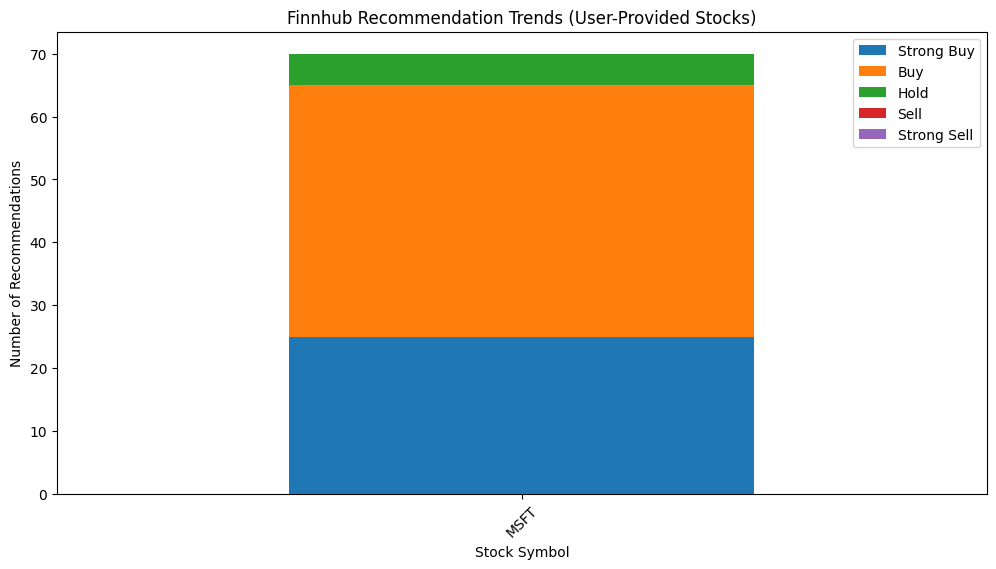

In [1]:
# =============================================================================
# Combined Code for Yahoo Finance and Finnhub Analyst Data with Flagging
# (FMP API recommendations have been removed)
# =============================================================================

# ---------------------------
# Section 1: Install Required Libraries
# ---------------------------
!pip install finnhub-python yfinance pandas requests matplotlib

# ---------------------------
# Section 2: Import Libraries
# ---------------------------
import yfinance as yf           # For Yahoo Finance data.
import pandas as pd             # For DataFrame creation and manipulation.
import requests                 # For making HTTP requests.
import finnhub                  # For Finnhub API access.
import matplotlib.pyplot as plt # For plotting stacked bar graphs.
from IPython.display import display, Markdown  # For prettier outputs in Colab.

# ---------------------------
# Section 3: Define Custom Styler Function
# ---------------------------
def highlight_strong(row):
    """
    Apply CSS styles to a DataFrame row:
      - For "Strong Buy" and "Strong Sell" cells with values > 0, apply a dark green background
        with white text (for better visibility in dark mode).
      - For the "Flag" cell (when non-empty), use bold, bright yellow text.
    """
    styles = []
    for col in row.index:
        if col in ['Strong Buy', 'Strong Sell'] and row[col] > 0:
            styles.append('background-color: #006400; color: white;')
        elif col == 'Flag' and row[col]:
            styles.append('font-weight: bold; color: yellow;')
        else:
            styles.append('')
    return styles

# ---------------------------
# Section 4: Define Functions for Yahoo Finance Data
# ---------------------------
def get_stock_rating(ticker):
    """
    Fetch the latest stock recommendation for a given ticker using yfinance.
    If numeric recommendation columns are present, extract them and flag if there
    is any strong buy or strong sell.
    """
    stock = yf.Ticker(ticker)

    try:
        recommendations = stock.recommendations
        if recommendations is not None and not recommendations.empty:
            print(f"\n{ticker} Recommendations DataFrame (last rows):")
            print(recommendations.tail())

            # Get the latest recommendation (last row of the DataFrame)
            latest_rating = recommendations.iloc[-1]
            date = (latest_rating.name if isinstance(latest_rating.name, str)
                    else str(latest_rating.name))

            if 'strongBuy' in recommendations.columns:
                strong_buy = latest_rating['strongBuy']
                buy = latest_rating['buy']
                hold = latest_rating['hold']
                sell = latest_rating['sell']
                strong_sell = latest_rating['strongSell']
                flag = ""
                if strong_buy > 0:
                    flag += "Strong Buy; "
                if strong_sell > 0:
                    flag += "Strong Sell; "
                flag = flag.strip().rstrip(';')
                return {
                    'Ticker': ticker,
                    'Date': date,
                    'Strong Buy': strong_buy,
                    'Buy': buy,
                    'Hold': hold,
                    'Sell': sell,
                    'Strong Sell': strong_sell,
                    'Flag': flag
                }
            else:
                firm = latest_rating.get('Firm', 'N/A')
                rating = latest_rating.get('To Grade', latest_rating.get('Action', 'N/A'))
                return {
                    'Ticker': ticker,
                    'Date': date,
                    'Firm': firm,
                    'Rating': rating,
                    'Flag': ""
                }
        else:
            print(f"No recommendations found for {ticker}")
            return {'Ticker': ticker, 'Date': 'N/A', 'Firm': 'N/A',
                    'Rating': 'No rating available', 'Flag': ""}
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        return {'Ticker': ticker, 'Date': 'N/A', 'Firm': 'N/A',
                'Rating': f'Error: {str(e)}', 'Flag': ""}

# ---------------------------
# Section 5: Prompt User for Ticker Symbols
# ---------------------------
user_input = input("Enter ticker symbols (separated by commas): ")
user_tickers = [ticker.strip().upper() for ticker in user_input.split(",") if ticker.strip() != ""]

# ---------------------------
# Section 6: Main Execution – Yahoo Finance Data
# ---------------------------
display(Markdown("## Stock Ratings from Yahoo Finance (yfinance)"))
yahoo_ratings = []
for ticker in user_tickers:
    rating = get_stock_rating(ticker)
    yahoo_ratings.append(rating)
    print(f"Processed {ticker}: {rating}")
yahoo_df = pd.DataFrame(yahoo_ratings)
print("\nFinal Yahoo Finance Ratings Data:")
display(yahoo_df.style.apply(highlight_strong, axis=1).hide(axis="index"))

# ---------------------------
# Section 7: Finnhub Data
# ---------------------------
# Set up Finnhub client using your API key.
finnhub_api_key = "cuia6c1r01qooddtr070cuia6c1r01qooddtr07g"  # Replace with your Finnhub API key.
finnhub_client = finnhub.Client(api_key=finnhub_api_key)

def get_finnhub_recommendation(symbol):
    """
    Retrieve the latest recommendation trends for a given symbol using Finnhub.
    """
    try:
        rec_trends = finnhub_client.recommendation_trends(symbol)
        if rec_trends and isinstance(rec_trends, list) and len(rec_trends) > 0:
            return rec_trends[0]
        else:
            print(f"No recommendation trends data available for {symbol}")
            return {}
    except Exception as e:
        print(f"Error retrieving recommendation trends for {symbol}: {str(e)}")
        return {}

# Use user-provided tickers for Finnhub as well.
finnhub_rec_list = []
for sym in user_tickers:
    rec = get_finnhub_recommendation(sym)
    if rec:
        strong_buy = rec.get('strongBuy', 0)
        buy = rec.get('buy', 0)
        hold = rec.get('hold', 0)
        sell = rec.get('sell', 0)
        strong_sell = rec.get('strongSell', 0)

        flag = ""
        if strong_buy > 0:
            flag += "Strong Buy; "
        if strong_sell > 0:
            flag += "Strong Sell; "
        flag = flag.strip().rstrip(';')

        finnhub_rec_list.append({
            'Ticker': sym,
            'Date': rec.get('period', 'N/A'),
            'Strong Buy': strong_buy,
            'Buy': buy,
            'Hold': hold,
            'Sell': sell,
            'Strong Sell': strong_sell,
            'Flag': flag
        })

finnhub_rec_df = pd.DataFrame(finnhub_rec_list)
display(Markdown("## Finnhub Recommendation Trends (User-Provided Stocks)"))
display(finnhub_rec_df.style.apply(highlight_strong, axis=1).hide(axis="index"))

# ---------------------------
# Section 8: Visualize Recommendations as Stacked Bar Graphs
# ---------------------------
def plot_stacked_bar(df, title):
    """
    Plot a stacked bar graph for recommendation trends.
    """
    df_copy = df.copy()
    df_copy.set_index('Ticker', inplace=True)
    df_copy[['Strong Buy', 'Buy', 'Hold', 'Sell', 'Strong Sell']].plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title(title)
    plt.ylabel('Number of Recommendations')
    plt.xlabel('Stock Symbol')
    plt.xticks(rotation=45)
    plt.show()

plot_stacked_bar(finnhub_rec_df, "Finnhub Recommendation Trends (User-Provided Stocks)")


## Stock Ratings from Yahoo Finance (yfinance)


AAPL Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m          7   21    14     2           2
1    -1m          8   21    13     2           2
2    -2m          8   24    12     1           2
3    -3m          8   24    12     1           2
Processed AAPL: {'Ticker': 'AAPL', 'Date': '3', 'Strong Buy': 8, 'Buy': 24, 'Hold': 12, 'Sell': 1, 'Strong Sell': 2, 'Flag': 'Strong Buy; Strong Sell'}

GOOGL Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m         15   36    12     0           0
1    -1m         15   36    12     0           0
2    -2m         16   36    11     0           0
3    -3m         16   37    11     0           0
Processed GOOGL: {'Ticker': 'GOOGL', 'Date': '3', 'Strong Buy': 16, 'Buy': 37, 'Hold': 11, 'Sell': 0, 'Strong Sell': 0, 'Flag': 'Strong Buy'}

MSFT Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m         13   37     5 

Ticker,Date,Strong Buy,Buy,Hold,Sell,Strong Sell,Flag
AAPL,3,8,24,12,1,2,Strong Buy; Strong Sell
GOOGL,3,16,37,11,0,0,Strong Buy
MSFT,3,14,38,5,0,0,Strong Buy
AMZN,3,17,47,4,0,0,Strong Buy
TSLA,3,5,13,17,8,5,Strong Buy; Strong Sell
META,3,12,47,8,0,2,Strong Buy; Strong Sell
UAA,3,2,5,16,2,1,Strong Buy; Strong Sell
NVDA,3,12,48,4,0,0,Strong Buy
INTC,3,1,4,35,2,4,Strong Buy; Strong Sell
AMD,3,7,32,11,0,0,Strong Buy


## Analyst Estimates and Recommendations from Financial Modeling Prep

Error retrieving analyst estimates for LIN, Status code: 403
Error retrieving analyst recommendations for LIN, Status code: 403
No combined data available for LIN
Error retrieving analyst estimates for BHP, Status code: 403
Error retrieving analyst recommendations for BHP, Status code: 403
No combined data available for BHP
Error retrieving analyst estimates for RIO, Status code: 403
Error retrieving analyst recommendations for RIO, Status code: 403
No combined data available for RIO
Error retrieving analyst estimates for SHW, Status code: 403
Error retrieving analyst recommendations for SHW, Status code: 403
No combined data available for SHW
Error retrieving analyst estimates for AI.PA, Status code: 403
Error retrieving analyst recommendations for AI.PA, Status code: 403
No combined data available for AI.PA
Error retrieving analyst estimates for SCCO, Status code: 403
Error retrieving analyst recommendations for SCCO, Status code: 403
No combined data available for SCCO
Error retriev

Symbol,Flag
LIN,
BHP,
RIO,
SHW,
AI.PA,
SCCO,
APD,
ECL,
CRH,
NGT.TO,


Error retrieving recommendation trends for RMS.PA: FinnhubAPIException(status_code: 403): You don't have access to this resource.
Error retrieving recommendation trends for AI.PA: FinnhubAPIException(status_code: 403): You don't have access to this resource.
No recommendation trends data available for VZA
Error retrieving recommendation trends for MC.PA: FinnhubAPIException(status_code: 403): You don't have access to this resource.
Error retrieving recommendation trends for VERIZ.BR: FinnhubAPIException(status_code: 403): You don't have access to this resource.
Error retrieving recommendation trends for NGT.TO: FinnhubAPIException(status_code: 403): You don't have access to this resource.


## Finnhub Recommendation Trends (All Stocks)

Ticker,Date,Strong Buy,Buy,Hold,Sell,Strong Sell,Flag
SCCO,2025-02-01,1,1,7,6,3,Strong Buy; Strong Sell
BHP,2025-02-01,4,8,8,0,1,Strong Buy; Strong Sell
NVDA,2025-02-01,24,38,7,0,0,Strong Buy
CRH,2025-02-01,7,13,3,0,0,Strong Buy
META,2025-02-01,23,45,8,2,0,Strong Buy
LOW,2025-02-01,9,15,16,2,0,Strong Buy
AMZN,2025-02-01,21,52,5,0,0,Strong Buy
MCD,2025-02-01,9,20,15,0,0,Strong Buy
NFLX,2025-02-01,15,25,14,0,0,Strong Buy
TSLA,2025-02-01,9,19,17,9,4,Strong Buy; Strong Sell


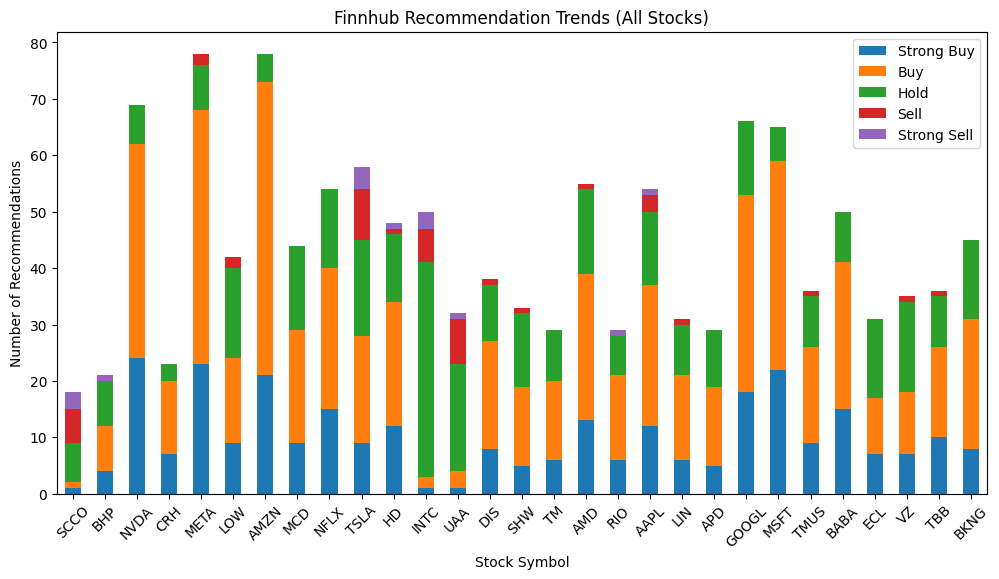

In [ ]:
# =============================================================================
# Combined Code for Yahoo Finance, FMP API, and Finnhub Analyst Data with Flagging
# =============================================================================

# ---------------------------
# Section 1: Install Required Libraries
# ---------------------------
!pip install finnhub-python yfinance pandas requests matplotlib

# ---------------------------
# Section 2: Import Libraries
# ---------------------------
import yfinance as yf           # For Yahoo Finance data.
import pandas as pd             # For DataFrame creation and manipulation.
import requests                 # To make HTTP requests to the FMP API.
import finnhub                  # For Finnhub API access.
import matplotlib.pyplot as plt # For plotting stacked bar graphs.
from IPython.display import display, Markdown  # For prettier outputs in Colab.

# ---------------------------
# Section 3: Define Custom Styler Function
# ---------------------------
def highlight_strong(row):
    """
    Apply CSS styles to a DataFrame row:
      - For "Strong Buy" and "Strong Sell" cells with values > 0, apply a dark green background
        with white text (for better visibility in dark mode).
      - For the "Flag" cell (when non-empty), use bold, bright yellow text.
    """
    styles = []
    for col in row.index:
        if col in ['Strong Buy', 'Strong Sell'] and row[col] > 0:
            styles.append('background-color: #006400; color: white;')  # Dark green background, white text
        elif col == 'Flag' and row[col]:
            styles.append('font-weight: bold; color: yellow;')  # Bold and yellow text for flagged cells
        else:
            styles.append('')
    return styles

# ---------------------------
# Section 4: Define Functions for Yahoo Finance Data
# ---------------------------
def get_stock_rating(ticker):
    """
    Fetch the latest stock recommendation for a given ticker using yfinance.
    If numeric recommendation columns are present (e.g., strongBuy, buy, etc.),
    extract those values and flag the ticker if there is any strong buy or strong sell.

    Parameters:
        ticker (str): Stock ticker symbol.

    Returns:
        dict: Contains the ticker, date, recommendation breakdown (if available),
              and a 'Flag' field with recommendation info.
    """
    stock = yf.Ticker(ticker)

    try:
        recommendations = stock.recommendations
        if recommendations is not None and not recommendations.empty:
            print(f"\n{ticker} Recommendations DataFrame (last rows):")
            print(recommendations.tail())

            # Get the latest recommendation (last row of the DataFrame)
            latest_rating = recommendations.iloc[-1]
            date = (latest_rating.name if isinstance(latest_rating.name, str)
                    else str(latest_rating.name))

            # If numeric columns exist, extract them.
            if 'strongBuy' in recommendations.columns:
                strong_buy = latest_rating['strongBuy']
                buy = latest_rating['buy']
                hold = latest_rating['hold']
                sell = latest_rating['sell']
                strong_sell = latest_rating['strongSell']
                flag = ""
                if strong_buy > 0:
                    flag += "Strong Buy; "
                if strong_sell > 0:
                    flag += "Strong Sell; "
                flag = flag.strip().rstrip(';')
                return {
                    'Ticker': ticker,
                    'Date': date,
                    'Strong Buy': strong_buy,
                    'Buy': buy,
                    'Hold': hold,
                    'Sell': sell,
                    'Strong Sell': strong_sell,
                    'Flag': flag
                }
            else:
                # Fallback if the expected numeric columns are not present.
                firm = latest_rating.get('Firm', 'N/A')
                rating = latest_rating.get('To Grade', latest_rating.get('Action', 'N/A'))
                return {
                    'Ticker': ticker,
                    'Date': date,
                    'Firm': firm,
                    'Rating': rating,
                    'Flag': ""
                }
        else:
            print(f"No recommendations found for {ticker}")
            return {'Ticker': ticker, 'Date': 'N/A', 'Firm': 'N/A',
                    'Rating': 'No rating available', 'Flag': ""}
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        return {'Ticker': ticker, 'Date': 'N/A', 'Firm': 'N/A',
                'Rating': f'Error: {str(e)}', 'Flag': ""}

# ---------------------------
# Section 5: Define Functions for FMP API Data
# ---------------------------
api_key = "vMjvwcHxD2EfJkJaXyrg79QE9OgkAlDY"  # Replace with your FMP API key.

def get_analyst_estimates(symbol):
    """
    Retrieve analyst estimates for a given company symbol from Financial Modeling Prep.
    """
    url = f"https://financialmodelingprep.com/api/v3/analyst-estimates/{symbol}?apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:
            return data[0]
        else:
            print(f"No analyst estimates data available for {symbol}")
            return None
    else:
        print(f"Error retrieving analyst estimates for {symbol}, Status code: {response.status_code}")
        return None

def get_analyst_recommendations(symbol):
    """
    Retrieve analyst recommendations for a given company symbol from Financial Modeling Prep.
    """
    url = f"https://financialmodelingprep.com/api/v3/analyst-stock-recommendations/{symbol}?apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:
            return data[0]
        else:
            print(f"No analyst recommendations data available for {symbol}")
            return None
    else:
        print(f"Error retrieving analyst recommendations for {symbol}, Status code: {response.status_code}")
        return None

def get_company_data(symbol):
    """
    Combine the analyst estimates and analyst recommendations for a given company symbol.
    """
    analyst_estimates = get_analyst_estimates(symbol)
    analyst_recommendations = get_analyst_recommendations(symbol)

    if analyst_estimates and analyst_recommendations:
        estimates = {
            'Estimated Revenue Avg': analyst_estimates.get('estimatedRevenueAvg', 'N/A'),
            'Estimated EPS Avg': analyst_estimates.get('estimatedEpsAvg', 'N/A'),
            'Estimated Net Income Avg': analyst_estimates.get('estimatedNetIncomeAvg', 'N/A')
        }
        recommendations = {
            'Strong Buy': analyst_recommendations.get('analystRatingsStrongBuy', 0),
            'Buy': analyst_recommendations.get('analystRatingsbuy', 0),
            'Hold': analyst_recommendations.get('analystRatingsHold', 0),
            'Sell': analyst_recommendations.get('analystRatingsSell', 0),
            'Strong Sell': analyst_recommendations.get('analystRatingsStrongSell', 0)
        }
        return estimates, recommendations
    else:
        print(f"No combined data available for {symbol}")
        return {}, {}

# ---------------------------
# Section 6: Main Execution and Output for Yahoo and FMP Data
# ---------------------------

# --- Part A: Yahoo Finance Section ---
display(Markdown("## Stock Ratings from Yahoo Finance (yfinance)"))

# List of tickers for Yahoo's data.
stock_tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'META', 'UAA', 'NVDA', 'INTC', 'AMD']

yahoo_ratings = []
for ticker in stock_tickers:
    rating = get_stock_rating(ticker)
    yahoo_ratings.append(rating)
    print(f"Processed {ticker}: {rating}")

yahoo_df = pd.DataFrame(yahoo_ratings)

print("\nFinal Yahoo Finance Ratings Data:")
display(yahoo_df.style.apply(highlight_strong, axis=1).hide(axis="index"))

# --- Part B: Financial Modeling Prep Section ---
display(Markdown("## Analyst Estimates and Recommendations from Financial Modeling Prep"))

# List of companies (tickers) to retrieve FMP data.
companies_from_images = [
    'LIN', 'BHP', 'RIO', 'SHW', 'AI.PA', 'SCCO', 'APD', 'ECL', 'CRH', 'NGT.TO',
    'GOOGL', 'META', 'NFLX', 'TMUS', 'VZA', 'VERIZ.BR', 'DIS', 'VZ', 'TBB',
    'AMZN', 'TSLA', 'HD', 'MC.PA', 'TM', 'RMS.PA', 'MCD', 'BABA', 'BKNG', 'LOW'
]

fmp_data_list = []
for symbol in companies_from_images:
    estimates, recommendations = get_company_data(symbol)

    combined_data = {'Symbol': symbol}
    combined_data.update(estimates)
    combined_data.update(recommendations)

    flag = ""
    if combined_data.get('Strong Buy', 0) > 0:
        flag += "Strong Buy; "
    if combined_data.get('Strong Sell', 0) > 0:
        flag += "Strong Sell; "
    flag = flag.strip().rstrip(';')
    combined_data['Flag'] = flag

    fmp_data_list.append(combined_data)

fmp_df = pd.DataFrame(fmp_data_list)

print("\nFinal FMP Analyst Estimates and Recommendations Data:")
display(fmp_df.style.apply(highlight_strong, axis=1).hide(axis="index"))

# ---------------------------
# Section 7: Finnhub Data
# ---------------------------

# Set up Finnhub client using the provided API key.
finnhub_api_key = "cuia6c1r01qooddtr070cuia6c1r01qooddtr07g"  # Replace with your Finnhub API key.
finnhub_client = finnhub.Client(api_key=finnhub_api_key)

def get_finnhub_recommendation(symbol):
    """
    Retrieve the latest recommendation trends for a given symbol using Finnhub.
    """
    try:
        rec_trends = finnhub_client.recommendation_trends(symbol)
        if rec_trends and isinstance(rec_trends, list):
            return rec_trends[0]
        else:
            print(f"No recommendation trends data available for {symbol}")
            return {}
    except Exception as e:
        print(f"Error retrieving recommendation trends for {symbol}: {str(e)}")
        return {}

# Get Finnhub recommendations for all stocks in the code.
all_stocks = list(set(stock_tickers + companies_from_images))  # Combine all tickers.
finnhub_rec_list = []

for sym in all_stocks:
    rec = get_finnhub_recommendation(sym)
    if rec:
        # Extract recommendation counts and add a flag.
        strong_buy = rec.get('strongBuy', 0)
        buy = rec.get('buy', 0)
        hold = rec.get('hold', 0)
        sell = rec.get('sell', 0)
        strong_sell = rec.get('strongSell', 0)

        flag = ""
        if strong_buy > 0:
            flag += "Strong Buy; "
        if strong_sell > 0:
            flag += "Strong Sell; "
        flag = flag.strip().rstrip(';')

        finnhub_rec_list.append({
            'Ticker': sym,
            'Date': rec.get('period', 'N/A'),
            'Strong Buy': strong_buy,
            'Buy': buy,
            'Hold': hold,
            'Sell': sell,
            'Strong Sell': strong_sell,
            'Flag': flag
        })

# Convert Finnhub recommendation trends to a DataFrame.
finnhub_rec_df = pd.DataFrame(finnhub_rec_list)
display(Markdown("## Finnhub Recommendation Trends (All Stocks)"))
display(finnhub_rec_df.style.apply(highlight_strong, axis=1).hide(axis="index"))

# ---------------------------
# Section 8: Visualize Recommendations as Stacked Bar Graphs
# ---------------------------
def plot_stacked_bar(df, title):
    """
    Plot a stacked bar graph for recommendation trends.
    """
    df.set_index('Ticker', inplace=True)
    df[['Strong Buy', 'Buy', 'Hold', 'Sell', 'Strong Sell']].plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title(title)
    plt.ylabel('Number of Recommendations')
    plt.xlabel('Stock Symbol')
    plt.xticks(rotation=45)
    plt.show()

# Plot stacked bar graph for Finnhub recommendations.
plot_stacked_bar(finnhub_rec_df, "Finnhub Recommendation Trends (All Stocks)")

## Stock Ratings from Yahoo Finance (yfinance)


AAPL Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m          7   21    14     2           2
1    -1m          8   21    13     2           2
2    -2m          8   24    12     1           2
3    -3m          8   24    12     1           2
Processed AAPL: {'Ticker': 'AAPL', 'Date': '3', 'Strong Buy': 8, 'Buy': 24, 'Hold': 12, 'Sell': 1, 'Strong Sell': 2, 'Flag': 'Strong Buy; Strong Sell'}

GOOGL Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m         15   36    12     0           0
1    -1m         15   36    12     0           0
2    -2m         16   36    11     0           0
3    -3m         16   37    11     0           0
Processed GOOGL: {'Ticker': 'GOOGL', 'Date': '3', 'Strong Buy': 16, 'Buy': 37, 'Hold': 11, 'Sell': 0, 'Strong Sell': 0, 'Flag': 'Strong Buy'}

MSFT Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m         13   37     5 

Ticker,Date,Strong Buy,Buy,Hold,Sell,Strong Sell,Flag
AAPL,3,8,24,12,1,2,Strong Buy; Strong Sell
GOOGL,3,16,37,11,0,0,Strong Buy
MSFT,3,14,38,5,0,0,Strong Buy
AMZN,3,17,47,4,0,0,Strong Buy
TSLA,3,5,13,17,8,5,Strong Buy; Strong Sell
META,3,12,47,8,0,2,Strong Buy; Strong Sell
UAA,3,2,5,16,2,1,Strong Buy; Strong Sell
NVDA,3,12,48,4,0,0,Strong Buy
INTC,3,1,4,35,2,4,Strong Buy; Strong Sell
AMD,3,7,32,11,0,0,Strong Buy


## Analyst Estimates and Recommendations from Financial Modeling Prep

Error retrieving analyst estimates for LIN, Status code: 403
Error retrieving analyst recommendations for LIN, Status code: 403
No combined data available for LIN
Error retrieving analyst estimates for BHP, Status code: 403
Error retrieving analyst recommendations for BHP, Status code: 403
No combined data available for BHP
Error retrieving analyst estimates for RIO, Status code: 403
Error retrieving analyst recommendations for RIO, Status code: 403
No combined data available for RIO
Error retrieving analyst estimates for SHW, Status code: 403
Error retrieving analyst recommendations for SHW, Status code: 403
No combined data available for SHW
Error retrieving analyst estimates for AI.PA, Status code: 403
Error retrieving analyst recommendations for AI.PA, Status code: 403
No combined data available for AI.PA
Error retrieving analyst estimates for SCCO, Status code: 403
Error retrieving analyst recommendations for SCCO, Status code: 403
No combined data available for SCCO
Error retriev

Symbol,Flag
LIN,
BHP,
RIO,
SHW,
AI.PA,
SCCO,
APD,
ECL,
CRH,
NGT.TO,


No recommendation trends data available for VZA
Error retrieving recommendation trends for VERIZ.BR: FinnhubAPIException(status_code: 403): You don't have access to this resource.
Error retrieving recommendation trends for NGT.TO: FinnhubAPIException(status_code: 403): You don't have access to this resource.
Error retrieving recommendation trends for RMS.PA: FinnhubAPIException(status_code: 403): You don't have access to this resource.
Error retrieving recommendation trends for AI.PA: FinnhubAPIException(status_code: 403): You don't have access to this resource.
Error retrieving recommendation trends for MC.PA: FinnhubAPIException(status_code: 403): You don't have access to this resource.


## Finnhub Recommendation Trends (All Stocks)

,buy,hold,period,sell,strongBuy,strongSell,symbol,Symbol
0,15.0,9.0,2025-02-01,1.0,6.0,0.0,LIN,LIN
1,25.0,13.0,2025-02-01,3.0,12.0,1.0,AAPL,AAPL
2,25.0,14.0,2025-02-01,0.0,15.0,0.0,NFLX,NFLX
3,11.0,16.0,2025-02-01,1.0,7.0,0.0,VZ,VZ
4,19.0,10.0,2025-02-01,1.0,8.0,0.0,DIS,DIS
5,38.0,7.0,2025-02-01,0.0,24.0,0.0,NVDA,NVDA
6,17.0,9.0,2025-02-01,1.0,9.0,0.0,TMUS,TMUS
7,14.0,10.0,2025-02-01,0.0,5.0,0.0,APD,APD
8,19.0,17.0,2025-02-01,9.0,9.0,4.0,TSLA,TSLA
9,15.0,16.0,2025-02-01,2.0,9.0,0.0,LOW,LOW


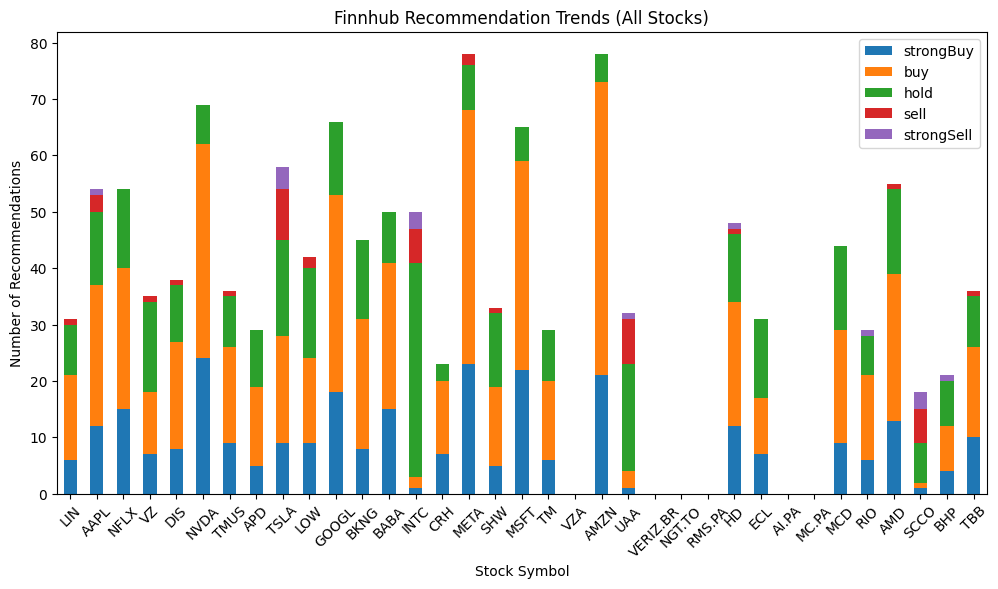

In [ ]:
# =============================================================================
# Combined Code for Yahoo Finance, FMP API, and Finnhub Analyst Data with Flagging
# =============================================================================

# ---------------------------
# Section 1: Install Required Libraries
# ---------------------------
!pip install finnhub-python yfinance pandas requests matplotlib

# ---------------------------
# Section 2: Import Libraries
# ---------------------------
import yfinance as yf           # For Yahoo Finance data.
import pandas as pd             # For DataFrame creation and manipulation.
import requests                 # To make HTTP requests to the FMP API.
import finnhub                  # For Finnhub API access.
import matplotlib.pyplot as plt # For plotting stacked bar graphs.
from IPython.display import display, Markdown  # For prettier outputs in Colab.

# ---------------------------
# Section 3: Define Custom Styler Function
# ---------------------------
def highlight_strong(row):
    """
    Apply CSS styles to a DataFrame row:
      - Highlight "Strong Buy" and "Strong Sell" cells (if their values > 0)
        with a light-green background.
      - Highlight the "Flag" cell with bold red text if it is non-empty.
    """
    styles = []
    for col in row.index:
        if col in ['Strong Buy', 'Strong Sell'] and row[col] > 0:
            styles.append('background-color: lightgreen')
        elif col == 'Flag' and row[col]:
            styles.append('font-weight: bold; color: red')
        else:
            styles.append('')
    return styles

# ---------------------------
# Section 4: Define Functions for Yahoo Finance Data
# ---------------------------
def get_stock_rating(ticker):
    """
    Fetch the latest stock recommendation for a given ticker using yfinance.
    If numeric recommendation columns are present (e.g., strongBuy, buy, etc.),
    extract those values and flag the ticker if there is any strong buy or strong sell.

    Parameters:
        ticker (str): Stock ticker symbol.

    Returns:
        dict: Contains the ticker, date, recommendation breakdown (if available),
              and a 'Flag' field with recommendation info.
    """
    stock = yf.Ticker(ticker)

    try:
        recommendations = stock.recommendations
        if recommendations is not None and not recommendations.empty:
            print(f"\n{ticker} Recommendations DataFrame (last rows):")
            print(recommendations.tail())

            # Get the latest recommendation (last row of the DataFrame)
            latest_rating = recommendations.iloc[-1]
            date = (latest_rating.name if isinstance(latest_rating.name, str)
                    else str(latest_rating.name))

            # If numeric columns exist, extract them.
            if 'strongBuy' in recommendations.columns:
                strong_buy = latest_rating['strongBuy']
                buy = latest_rating['buy']
                hold = latest_rating['hold']
                sell = latest_rating['sell']
                strong_sell = latest_rating['strongSell']
                flag = ""
                if strong_buy > 0:
                    flag += "Strong Buy; "
                if strong_sell > 0:
                    flag += "Strong Sell; "
                flag = flag.strip().rstrip(';')
                return {
                    'Ticker': ticker,
                    'Date': date,
                    'Strong Buy': strong_buy,
                    'Buy': buy,
                    'Hold': hold,
                    'Sell': sell,
                    'Strong Sell': strong_sell,
                    'Flag': flag
                }
            else:
                # Fallback if the expected numeric columns are not present.
                firm = latest_rating.get('Firm', 'N/A')
                rating = latest_rating.get('To Grade', latest_rating.get('Action', 'N/A'))
                return {
                    'Ticker': ticker,
                    'Date': date,
                    'Firm': firm,
                    'Rating': rating,
                    'Flag': ""
                }
        else:
            print(f"No recommendations found for {ticker}")
            return {'Ticker': ticker, 'Date': 'N/A', 'Firm': 'N/A',
                    'Rating': 'No rating available', 'Flag': ""}
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        return {'Ticker': ticker, 'Date': 'N/A', 'Firm': 'N/A',
                'Rating': f'Error: {str(e)}', 'Flag': ""}

# ---------------------------
# Section 5: Define Functions for FMP API Data
# ---------------------------
api_key = "vMjvwcHxD2EfJkJaXyrg79QE9OgkAlDY"  # Replace with your FMP API key.

def get_analyst_estimates(symbol):
    """
    Retrieve analyst estimates for a given company symbol from Financial Modeling Prep.
    """
    url = f"https://financialmodelingprep.com/api/v3/analyst-estimates/{symbol}?apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:
            return data[0]
        else:
            print(f"No analyst estimates data available for {symbol}")
            return None
    else:
        print(f"Error retrieving analyst estimates for {symbol}, Status code: {response.status_code}")
        return None

def get_analyst_recommendations(symbol):
    """
    Retrieve analyst recommendations for a given company symbol from Financial Modeling Prep.
    """
    url = f"https://financialmodelingprep.com/api/v3/analyst-stock-recommendations/{symbol}?apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:
            return data[0]
        else:
            print(f"No analyst recommendations data available for {symbol}")
            return None
    else:
        print(f"Error retrieving analyst recommendations for {symbol}, Status code: {response.status_code}")
        return None

def get_company_data(symbol):
    """
    Combine the analyst estimates and analyst recommendations for a given company symbol.
    """
    analyst_estimates = get_analyst_estimates(symbol)
    analyst_recommendations = get_analyst_recommendations(symbol)

    if analyst_estimates and analyst_recommendations:
        estimates = {
            'Estimated Revenue Avg': analyst_estimates.get('estimatedRevenueAvg', 'N/A'),
            'Estimated EPS Avg': analyst_estimates.get('estimatedEpsAvg', 'N/A'),
            'Estimated Net Income Avg': analyst_estimates.get('estimatedNetIncomeAvg', 'N/A')
        }
        recommendations = {
            'Strong Buy': analyst_recommendations.get('analystRatingsStrongBuy', 0),
            'Buy': analyst_recommendations.get('analystRatingsbuy', 0),
            'Hold': analyst_recommendations.get('analystRatingsHold', 0),
            'Sell': analyst_recommendations.get('analystRatingsSell', 0),
            'Strong Sell': analyst_recommendations.get('analystRatingsStrongSell', 0)
        }
        return estimates, recommendations
    else:
        print(f"No combined data available for {symbol}")
        return {}, {}

# ---------------------------
# Section 6: Main Execution and Output for Yahoo and FMP Data
# ---------------------------

# --- Part A: Yahoo Finance Section ---
display(Markdown("## Stock Ratings from Yahoo Finance (yfinance)"))

# List of tickers for Yahoo's data.
stock_tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'META', 'UAA', 'NVDA', 'INTC', 'AMD']

yahoo_ratings = []
for ticker in stock_tickers:
    rating = get_stock_rating(ticker)
    yahoo_ratings.append(rating)
    print(f"Processed {ticker}: {rating}")

yahoo_df = pd.DataFrame(yahoo_ratings)

print("\nFinal Yahoo Finance Ratings Data:")
display(yahoo_df.style.apply(highlight_strong, axis=1).hide(axis="index"))

# --- Part B: Financial Modeling Prep Section ---
display(Markdown("## Analyst Estimates and Recommendations from Financial Modeling Prep"))

# List of companies (tickers) to retrieve FMP data.
companies_from_images = [
    'LIN', 'BHP', 'RIO', 'SHW', 'AI.PA', 'SCCO', 'APD', 'ECL', 'CRH', 'NGT.TO',
    'GOOGL', 'META', 'NFLX', 'TMUS', 'VZA', 'VERIZ.BR', 'DIS', 'VZ', 'TBB',
    'AMZN', 'TSLA', 'HD', 'MC.PA', 'TM', 'RMS.PA', 'MCD', 'BABA', 'BKNG', 'LOW'
]

fmp_data_list = []
for symbol in companies_from_images:
    estimates, recommendations = get_company_data(symbol)

    combined_data = {'Symbol': symbol}
    combined_data.update(estimates)
    combined_data.update(recommendations)

    flag = ""
    if combined_data.get('Strong Buy', 0) > 0:
        flag += "Strong Buy; "
    if combined_data.get('Strong Sell', 0) > 0:
        flag += "Strong Sell; "
    flag = flag.strip().rstrip(';')
    combined_data['Flag'] = flag

    fmp_data_list.append(combined_data)

fmp_df = pd.DataFrame(fmp_data_list)

print("\nFinal FMP Analyst Estimates and Recommendations Data:")
display(fmp_df.style.apply(highlight_strong, axis=1).hide(axis="index"))

# ---------------------------
# Section 7: Finnhub Data
# ---------------------------

# Set up Finnhub client using the provided API key.
finnhub_api_key = "cuia6c1r01qooddtr070cuia6c1r01qooddtr07g"  # Replace with your Finnhub API key.
finnhub_client = finnhub.Client(api_key=finnhub_api_key)

def get_finnhub_recommendation(symbol):
    """
    Retrieve the latest recommendation trends for a given symbol using Finnhub.
    """
    try:
        rec_trends = finnhub_client.recommendation_trends(symbol)
        if rec_trends and isinstance(rec_trends, list):
            return rec_trends[0]
        else:
            print(f"No recommendation trends data available for {symbol}")
            return {}
    except Exception as e:
        print(f"Error retrieving recommendation trends for {symbol}: {str(e)}")
        return {}

# Get Finnhub recommendations for all stocks in the code.
all_stocks = list(set(stock_tickers + companies_from_images))  # Combine all tickers.
finnhub_rec_list = []

for sym in all_stocks:
    rec = get_finnhub_recommendation(sym)
    rec['Symbol'] = sym  # Ensure the symbol is included.
    finnhub_rec_list.append(rec)

# Convert Finnhub recommendation trends to a DataFrame.
finnhub_rec_df = pd.DataFrame(finnhub_rec_list)
display(Markdown("## Finnhub Recommendation Trends (All Stocks)"))
display(finnhub_rec_df)

# ---------------------------
# Section 8: Visualize Recommendations as Stacked Bar Graphs
# ---------------------------
def plot_stacked_bar(df, title):
    """
    Plot a stacked bar graph for recommendation trends.
    """
    df.set_index('Symbol', inplace=True)
    df[['strongBuy', 'buy', 'hold', 'sell', 'strongSell']].plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title(title)
    plt.ylabel('Number of Recommendations')
    plt.xlabel('Stock Symbol')
    plt.xticks(rotation=45)
    plt.show()

# Plot stacked bar graph for Finnhub recommendations.
plot_stacked_bar(finnhub_rec_df, "Finnhub Recommendation Trends (All Stocks)")

In [ ]:
# Install the finnhub package (only needs to be done once)
!pip install finnhub-python

# =============================================================================
# Combined Code for Yahoo Finance, FMP API, and Finnhub Analyst Data with Flagging
#
# This script does the following:
# 1. Uses yfinance to fetch the latest analyst recommendations for a list of
#    stock tickers (Yahoo's data). If numeric recommendation data exists, it
#    flags any strong buy or strong sell signals.
#
# 2. Uses the Financial Modeling Prep (FMP) API to fetch both analyst estimates
#    and analyst recommendations for another list of companies.
#    FMP endpoints used:
#       - Analyst Recommendations:
#         https://financialmodelingprep.com/api/v3/analyst-stock-recommendations/<symbol>?apikey=<API_KEY>
#       - Analyst Estimates:
#         https://financialmodelingprep.com/api/v3/analyst-estimates/<symbol>?apikey=<API_KEY>
#
# 3. Uses the Finnhub API to fetch recommendation trends and earnings surprises.
#    Finnhub endpoints used:
#       - Recommendation Trends: /stock/recommendation?symbol=<symbol>
#       - Earnings Surprises: /stock/earnings?symbol=<symbol>
#
# 4. Applies custom styling (via Pandas Styler) to highlight cells that have
#    strong buy or strong sell signals.
#
# This code is intended to run in Google Colab.
# =============================================================================

import yfinance as yf           # For Yahoo Finance data.
import pandas as pd             # For DataFrame creation and manipulation.
import requests                 # To make HTTP requests to the FMP API.
import finnhub                # For Finnhub API access.
from IPython.display import display, Markdown  # For prettier outputs in Colab.

# ---------------------------
# Section 2: Define Custom Styler Function
# ---------------------------
def highlight_strong(row):
    """
    Apply CSS styles to a DataFrame row:
      - Highlight "Strong Buy" and "Strong Sell" cells (if their values > 0)
        with a light-green background.
      - Highlight the "Flag" cell with bold red text if it is non-empty.
    """
    styles = []
    for col in row.index:
        if col in ['Strong Buy', 'Strong Sell'] and row[col] > 0:
            styles.append('background-color: lightgreen')
        elif col == 'Flag' and row[col]:
            styles.append('font-weight: bold; color: red')
        else:
            styles.append('')
    return styles

# -------------------------------------------
# Section 3: Define Functions for Yahoo Finance Data
# -------------------------------------------
def get_stock_rating(ticker):
    """
    Fetch the latest stock recommendation for a given ticker using yfinance.
    If numeric recommendation columns are present (e.g., strongBuy, buy, etc.),
    extract those values and flag the ticker if there is any strong buy or strong sell.

    Parameters:
        ticker (str): Stock ticker symbol.

    Returns:
        dict: Contains the ticker, date, recommendation breakdown (if available),
              and a 'Flag' field with recommendation info.
    """
    stock = yf.Ticker(ticker)

    try:
        recommendations = stock.recommendations
        if recommendations is not None and not recommendations.empty:
            print(f"\n{ticker} Recommendations DataFrame (last rows):")
            print(recommendations.tail())

            # Get the latest recommendation (last row of the DataFrame)
            latest_rating = recommendations.iloc[-1]
            date = (latest_rating.name if isinstance(latest_rating.name, str)
                    else str(latest_rating.name))

            # If numeric columns exist, extract them.
            if 'strongBuy' in recommendations.columns:
                strong_buy = latest_rating['strongBuy']
                buy = latest_rating['buy']
                hold = latest_rating['hold']
                sell = latest_rating['sell']
                strong_sell = latest_rating['strongSell']
                flag = ""
                if strong_buy > 0:
                    flag += "Strong Buy; "
                if strong_sell > 0:
                    flag += "Strong Sell; "
                flag = flag.strip().rstrip(';')
                return {
                    'Ticker': ticker,
                    'Date': date,
                    'Strong Buy': strong_buy,
                    'Buy': buy,
                    'Hold': hold,
                    'Sell': sell,
                    'Strong Sell': strong_sell,
                    'Flag': flag
                }
            else:
                # Fallback if the expected numeric columns are not present.
                firm = latest_rating.get('Firm', 'N/A')
                rating = latest_rating.get('To Grade', latest_rating.get('Action', 'N/A'))
                return {
                    'Ticker': ticker,
                    'Date': date,
                    'Firm': firm,
                    'Rating': rating,
                    'Flag': ""
                }
        else:
            print(f"No recommendations found for {ticker}")
            return {'Ticker': ticker, 'Date': 'N/A', 'Firm': 'N/A',
                    'Rating': 'No rating available', 'Flag': ""}
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        return {'Ticker': ticker, 'Date': 'N/A', 'Firm': 'N/A',
                'Rating': f'Error: {str(e)}', 'Flag': ""}

# -----------------------------------------------
# Section 4: Define Functions for FMP API Data
# -----------------------------------------------

# Replace with your actual Financial Modeling Prep API key.
api_key = "vMjvwcHxD2EfJkJaXyrg79QE9OgkAlDY"

def get_analyst_estimates(symbol):
    """
    Retrieve analyst estimates for a given company symbol from Financial Modeling Prep.

    Parameters:
        symbol (str): Company ticker symbol.

    Returns:
        dict or None: The first set of estimates returned by the API, or None if not available.
    """
    url = f"https://financialmodelingprep.com/api/v3/analyst-estimates/{symbol}?apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:  # Ensure the data is not empty.
            return data[0]  # Return the first set of estimates.
        else:
            print(f"No analyst estimates data available for {symbol}")
            return None
    else:
        print(f"Error retrieving analyst estimates for {symbol}, Status code: {response.status_code}")
        return None

def get_analyst_recommendations(symbol):
    """
    Retrieve analyst recommendations for a given company symbol from Financial Modeling Prep.

    Parameters:
        symbol (str): Company ticker symbol.

    Returns:
        dict or None: The first set of recommendations returned by the API, or None if not available.
    """
    url = f"https://financialmodelingprep.com/api/v3/analyst-stock-recommendations/{symbol}?apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:  # Ensure the data is not empty.
            return data[0]  # Return the first set of recommendations.
        else:
            print(f"No analyst recommendations data available for {symbol}")
            return None
    else:
        print(f"Error retrieving analyst recommendations for {symbol}, Status code: {response.status_code}")
        return None

def get_company_data(symbol):
    """
    Combine the analyst estimates and analyst recommendations for a given company symbol.
    Also, create a flag if there are any strong buy or strong sell recommendations.

    Parameters:
        symbol (str): Company ticker symbol.

    Returns:
        tuple: Two dictionaries containing estimates and recommendations, respectively.
    """
    analyst_estimates = get_analyst_estimates(symbol)
    analyst_recommendations = get_analyst_recommendations(symbol)

    if analyst_estimates and analyst_recommendations:
        # Extract key estimate values.
        estimates = {
            'Estimated Revenue Avg': analyst_estimates.get('estimatedRevenueAvg', 'N/A'),
            'Estimated EPS Avg': analyst_estimates.get('estimatedEpsAvg', 'N/A'),
            'Estimated Net Income Avg': analyst_estimates.get('estimatedNetIncomeAvg', 'N/A')
        }
        # Extract recommendation counts.
        recommendations = {
            'Strong Buy': analyst_recommendations.get('analystRatingsStrongBuy', 0),
            'Buy': analyst_recommendations.get('analystRatingsbuy', 0),
            'Hold': analyst_recommendations.get('analystRatingsHold', 0),
            'Sell': analyst_recommendations.get('analystRatingsSell', 0),
            'Strong Sell': analyst_recommendations.get('analystRatingsStrongSell', 0)
        }
        return estimates, recommendations
    else:
        print(f"No combined data available for {symbol}")
        return {}, {}

# --------------------------------------
# Section 5: Main Execution and Output for Yahoo and FMP Data
# --------------------------------------

# --- Part A: Yahoo Finance Section ---
display(Markdown("## Stock Ratings from Yahoo Finance (yfinance)"))

# List of tickers for Yahoo's data.
stock_tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'META', 'UAA', 'NVDA', 'INTC', 'AMD']

yahoo_ratings = []
for ticker in stock_tickers:
    rating = get_stock_rating(ticker)
    yahoo_ratings.append(rating)
    print(f"Processed {ticker}: {rating}")

yahoo_df = pd.DataFrame(yahoo_ratings)

print("\nFinal Yahoo Finance Ratings Data:")
# Apply the custom styling to highlight strong recommendations and flags.
display(yahoo_df.style.apply(highlight_strong, axis=1).hide(axis="index"))

# --- Part B: Financial Modeling Prep Section ---
display(Markdown("## Analyst Estimates and Recommendations from Financial Modeling Prep"))

# List of companies (tickers) to retrieve FMP data.
companies_from_images = [
    'LIN', 'BHP', 'RIO', 'SHW', 'AI.PA', 'SCCO', 'APD', 'ECL', 'CRH', 'NGT.TO',
    'GOOGL', 'META', 'NFLX', 'TMUS', 'VZA', 'VERIZ.BR', 'DIS', 'VZ', 'TBB',
    'AMZN', 'TSLA', 'HD', 'MC.PA', 'TM', 'RMS.PA', 'MCD', 'BABA', 'BKNG', 'LOW'
]

fmp_data_list = []
for symbol in companies_from_images:
    estimates, recommendations = get_company_data(symbol)

    # Create a combined dictionary with the symbol, estimates, and recommendations.
    combined_data = {'Symbol': symbol}
    combined_data.update(estimates)
    combined_data.update(recommendations)

    # Create a flag based on FMP recommendations.
    flag = ""
    if combined_data.get('Strong Buy', 0) > 0:
        flag += "Strong Buy; "
    if combined_data.get('Strong Sell', 0) > 0:
        flag += "Strong Sell; "
    flag = flag.strip().rstrip(';')
    combined_data['Flag'] = flag

    fmp_data_list.append(combined_data)

fmp_df = pd.DataFrame(fmp_data_list)

print("\nFinal FMP Analyst Estimates and Recommendations Data:")
display(fmp_df.style.apply(highlight_strong, axis=1).hide(axis="index"))

# --------------------------------------
# Section 6: Finnhub Data
# --------------------------------------

# Set up Finnhub client using the provided API key.
finnhub_api_key = "cuia6c1r01qooddtr070cuia6c1r01qooddtr07g"
finnhub_client = finnhub.Client(api_key=finnhub_api_key)

# Define a function to get Finnhub recommendation trends.
def get_finnhub_recommendation(symbol):
    """
    Retrieve the latest recommendation trends for a given symbol using Finnhub.

    Returns the first (most recent) recommendation trend as a dictionary.
    """
    try:
        rec_trends = finnhub_client.recommendation_trends(symbol)
        if rec_trends and isinstance(rec_trends, list):
            # Return the first element (assumed most recent)
            return rec_trends[0]
        else:
            print(f"No recommendation trends data available for {symbol}")
            return {}
    except Exception as e:
        print(f"Error retrieving recommendation trends for {symbol}: {str(e)}")
        return {}

# Define a function to get earnings surprises from Finnhub.
def get_finnhub_earnings(symbol, limit=4):
    """
    Retrieve historical quarterly earnings surprises for a given symbol using Finnhub.
    Returns a list of earnings reports (limited by the provided 'limit').
    """
    try:
        earnings = finnhub_client.company_earnings(symbol, limit=limit)
        return earnings
    except Exception as e:
        print(f"Error retrieving earnings for {symbol}: {str(e)}")
        return []

# Now, process a sample list of symbols for Finnhub data.
finnhub_symbols = ['AAPL', 'TSLA', 'GOOGL']  # You can modify this list as needed.
finnhub_rec_list = []
finnhub_earnings_list = []

for sym in finnhub_symbols:
    # Get recommendation trends.
    rec = get_finnhub_recommendation(sym)
    rec['Symbol'] = sym  # Ensure the symbol is included.
    finnhub_rec_list.append(rec)

    # Get earnings surprises (last 4 quarters).
    earnings = get_finnhub_earnings(sym, limit=4)
    finnhub_earnings_list.append({'Symbol': sym, 'Earnings': earnings})

# Convert Finnhub recommendation trends to a DataFrame.
finnhub_rec_df = pd.DataFrame(finnhub_rec_list)
display(Markdown("## Finnhub Recommendation Trends"))
display(finnhub_rec_df)

# Display earnings surprises for each symbol.
display(Markdown("## Finnhub Earnings Surprises (Last 4 Quarters)"))
for item in finnhub_earnings_list:
    symbol = item['Symbol']
    earnings_data = item['Earnings']
    display(Markdown(f"### {symbol} Earnings"))
    if earnings_data:
        earnings_df = pd.DataFrame(earnings_data)
        display(earnings_df)
    else:
        display(Markdown("No earnings data available"))


## Stock Ratings from Yahoo Finance (yfinance)


AAPL Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m          7   21    14     2           2
1    -1m          8   21    13     2           2
2    -2m          8   24    12     1           2
3    -3m          8   24    12     1           2
Processed AAPL: {'Ticker': 'AAPL', 'Date': '3', 'Strong Buy': 8, 'Buy': 24, 'Hold': 12, 'Sell': 1, 'Strong Sell': 2, 'Flag': 'Strong Buy; Strong Sell'}

GOOGL Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m         15   36    12     0           0
1    -1m         15   36    12     0           0
2    -2m         16   36    11     0           0
3    -3m         16   37    11     0           0
Processed GOOGL: {'Ticker': 'GOOGL', 'Date': '3', 'Strong Buy': 16, 'Buy': 37, 'Hold': 11, 'Sell': 0, 'Strong Sell': 0, 'Flag': 'Strong Buy'}

MSFT Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m         13   37     5 

Ticker,Date,Strong Buy,Buy,Hold,Sell,Strong Sell,Flag
AAPL,3,8,24,12,1,2,Strong Buy; Strong Sell
GOOGL,3,16,37,11,0,0,Strong Buy
MSFT,3,14,38,5,0,0,Strong Buy
AMZN,3,17,47,4,0,0,Strong Buy
TSLA,3,5,13,17,8,5,Strong Buy; Strong Sell
META,3,12,47,8,0,2,Strong Buy; Strong Sell
UAA,3,2,5,16,2,1,Strong Buy; Strong Sell
NVDA,3,12,48,4,0,0,Strong Buy
INTC,3,1,4,35,2,4,Strong Buy; Strong Sell
AMD,3,7,32,11,0,0,Strong Buy


## Analyst Estimates and Recommendations from Financial Modeling Prep

Error retrieving analyst estimates for LIN, Status code: 403
Error retrieving analyst recommendations for LIN, Status code: 403
No combined data available for LIN
Error retrieving analyst estimates for BHP, Status code: 403
Error retrieving analyst recommendations for BHP, Status code: 403
No combined data available for BHP
Error retrieving analyst estimates for RIO, Status code: 403
Error retrieving analyst recommendations for RIO, Status code: 403
No combined data available for RIO
Error retrieving analyst estimates for SHW, Status code: 403
Error retrieving analyst recommendations for SHW, Status code: 403
No combined data available for SHW
Error retrieving analyst estimates for AI.PA, Status code: 403
Error retrieving analyst recommendations for AI.PA, Status code: 403
No combined data available for AI.PA
Error retrieving analyst estimates for SCCO, Status code: 403
Error retrieving analyst recommendations for SCCO, Status code: 403
No combined data available for SCCO
Error retriev

Symbol,Flag
LIN,
BHP,
RIO,
SHW,
AI.PA,
SCCO,
APD,
ECL,
CRH,
NGT.TO,


## Finnhub Recommendation Trends

,buy,hold,period,sell,strongBuy,strongSell,symbol,Symbol
0,25,13,2025-02-01,3,12,1,AAPL,AAPL
1,19,17,2025-02-01,9,9,4,TSLA,TSLA
2,35,13,2025-02-01,0,18,0,GOOGL,GOOGL


## Finnhub Earnings Surprises (Last 4 Quarters)

### AAPL Earnings

,actual,estimate,period,quarter,surprise,surprisePercent,symbol,year
0,2.40,2.3964,2024-12-31,1,0.0036,0.1502,AAPL,2025
1,1.64,1.6343,2024-09-30,4,0.0057,0.3488,AAPL,2024
2,1.40,1.3732,2024-06-30,3,0.0268,1.9516,AAPL,2024
3,1.53,1.5304,2024-03-31,2,-0.0004,-0.0261,AAPL,2024


### TSLA Earnings

,actual,estimate,period,quarter,surprise,surprisePercent,symbol,year
0,0.73,0.7777,2024-12-31,4,-0.0477,-6.1335,TSLA,2024
1,0.72,0.5959,2024-09-30,3,0.1241,20.8256,TSLA,2024
2,0.52,0.6361,2024-06-30,2,-0.1161,-18.2518,TSLA,2024
3,0.45,0.5117,2024-03-31,1,-0.0617,-12.0578,TSLA,2024


### GOOGL Earnings

,actual,estimate,period,quarter,surprise,surprisePercent,symbol,year
0,2.15,2.1917,2024-12-31,4,-0.0417,-1.9026,GOOGL,2024
1,2.12,1.9009,2024-09-30,3,0.2191,11.5261,GOOGL,2024
2,1.89,1.8998,2024-06-30,2,-0.0098,-0.5158,GOOGL,2024
3,1.89,1.5602,2024-03-31,1,0.3298,21.1383,GOOGL,2024


In [ ]:
# =============================================================================
# Combined Code for Yahoo Finance and FMP API Analyst Data with Flagging
#
# This script does the following:
# 1. Uses yfinance to fetch the latest analyst recommendations for a list of
#    stock tickers (Yahoo's data). If numeric recommendation data exists, it
#    flags any strong buy or strong sell recommendations.
#
# 2. Uses the Financial Modeling Prep (FMP) API to fetch both analyst estimates
#    and analyst recommendations for another list of companies.
#    The FMP endpoints used are:
#       - Analyst Recommendations:
#         https://financialmodelingprep.com/api/v3/analyst-stock-recommendations/<symbol>?apikey=<API_KEY>
#       - Analyst Estimates:
#         https://financialmodelingprep.com/api/v3/analyst-estimates/<symbol>?apikey=<API_KEY>
#
# 3. Applies custom styling (via Pandas Styler) to highlight cells that have
#    strong buy or strong sell signals.
#
# This code is intended to run in Google Colab.
# =============================================================================

# ---------------------------
# Section 1: Import Libraries
# ---------------------------
import yfinance as yf           # For Yahoo Finance data.
import pandas as pd             # For DataFrame creation and manipulation.
import requests                 # To make HTTP requests to the FMP API.
from IPython.display import display, Markdown  # For prettier outputs in Colab.

# ---------------------------
# Section 2: Define Custom Styler Function
# ---------------------------
def highlight_strong(row):
    """
    Apply CSS styles to a DataFrame row:
      - Highlight "Strong Buy" and "Strong Sell" cells (if their values > 0)
        with a light-green background.
      - Highlight the "Flag" cell with bold red text if it is non-empty.
    """
    styles = []
    for col in row.index:
        if col in ['Strong Buy', 'Strong Sell'] and row[col] > 0:
            styles.append('background-color: lightgreen')
        elif col == 'Flag' and row[col]:
            styles.append('font-weight: bold; color: red')
        else:
            styles.append('')
    return styles

# -------------------------------------------
# Section 3: Define Functions for Yahoo Finance Data
# -------------------------------------------
def get_stock_rating(ticker):
    """
    Fetch the latest stock recommendation for a given ticker using yfinance.
    If numeric recommendation columns are present (e.g., strongBuy, buy, etc.),
    extract those values and flag the ticker if there is any strong buy or strong sell.

    Parameters:
        ticker (str): Stock ticker symbol.

    Returns:
        dict: Contains the ticker, date, recommendation breakdown (if available),
              and a 'Flag' field with recommendation info.
    """
    stock = yf.Ticker(ticker)

    try:
        recommendations = stock.recommendations
        if recommendations is not None and not recommendations.empty:
            print(f"\n{ticker} Recommendations DataFrame (last rows):")
            print(recommendations.tail())

            # Get the latest recommendation (last row of the DataFrame)
            latest_rating = recommendations.iloc[-1]
            date = (latest_rating.name if isinstance(latest_rating.name, str)
                    else str(latest_rating.name))

            # If numeric columns exist, extract them.
            if 'strongBuy' in recommendations.columns:
                strong_buy = latest_rating['strongBuy']
                buy = latest_rating['buy']
                hold = latest_rating['hold']
                sell = latest_rating['sell']
                strong_sell = latest_rating['strongSell']
                flag = ""
                if strong_buy > 0:
                    flag += "Strong Buy; "
                if strong_sell > 0:
                    flag += "Strong Sell; "
                flag = flag.strip().rstrip(';')
                return {
                    'Ticker': ticker,
                    'Date': date,
                    'Strong Buy': strong_buy,
                    'Buy': buy,
                    'Hold': hold,
                    'Sell': sell,
                    'Strong Sell': strong_sell,
                    'Flag': flag
                }
            else:
                # Fallback if the expected numeric columns are not present.
                firm = latest_rating.get('Firm', 'N/A')
                rating = latest_rating.get('To Grade', latest_rating.get('Action', 'N/A'))
                return {
                    'Ticker': ticker,
                    'Date': date,
                    'Firm': firm,
                    'Rating': rating,
                    'Flag': ""
                }
        else:
            print(f"No recommendations found for {ticker}")
            return {'Ticker': ticker, 'Date': 'N/A', 'Firm': 'N/A',
                    'Rating': 'No rating available', 'Flag': ""}
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        return {'Ticker': ticker, 'Date': 'N/A', 'Firm': 'N/A',
                'Rating': f'Error: {str(e)}', 'Flag': ""}

# -----------------------------------------------
# Section 4: Define Functions for FMP API Data
# -----------------------------------------------

# Replace with your actual Financial Modeling Prep API key.
api_key = "vMjvwcHxD2EfJkJaXyrg79QE9OgkAlDY"

def get_analyst_estimates(symbol):
    """
    Retrieve analyst estimates for a given company symbol from Financial Modeling Prep.

    Parameters:
        symbol (str): Company ticker symbol.

    Returns:
        dict or None: The first set of estimates returned by the API, or None if not available.
    """
    url = f"https://financialmodelingprep.com/api/v3/analyst-estimates/{symbol}?apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:  # Ensure the data is not empty.
            return data[0]  # Return the first set of estimates.
        else:
            print(f"No analyst estimates data available for {symbol}")
            return None
    else:
        print(f"Error retrieving analyst estimates for {symbol}, Status code: {response.status_code}")
        return None

def get_analyst_recommendations(symbol):
    """
    Retrieve analyst recommendations for a given company symbol from Financial Modeling Prep.

    Parameters:
        symbol (str): Company ticker symbol.

    Returns:
        dict or None: The first set of recommendations returned by the API, or None if not available.
    """
    url = f"https://financialmodelingprep.com/api/v3/analyst-stock-recommendations/{symbol}?apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:  # Ensure the data is not empty.
            return data[0]  # Return the first set of recommendations.
        else:
            print(f"No analyst recommendations data available for {symbol}")
            return None
    else:
        print(f"Error retrieving analyst recommendations for {symbol}, Status code: {response.status_code}")
        return None

def get_company_data(symbol):
    """
    Combine the analyst estimates and analyst recommendations for a given company symbol.
    Also, create a flag if there are any strong buy or strong sell recommendations.

    Parameters:
        symbol (str): Company ticker symbol.

    Returns:
        tuple: Two dictionaries containing estimates and recommendations, respectively.
    """
    analyst_estimates = get_analyst_estimates(symbol)
    analyst_recommendations = get_analyst_recommendations(symbol)

    if analyst_estimates and analyst_recommendations:
        # Extract key estimate values.
        estimates = {
            'Estimated Revenue Avg': analyst_estimates.get('estimatedRevenueAvg', 'N/A'),
            'Estimated EPS Avg': analyst_estimates.get('estimatedEpsAvg', 'N/A'),
            'Estimated Net Income Avg': analyst_estimates.get('estimatedNetIncomeAvg', 'N/A')
        }
        # Extract recommendation counts.
        recommendations = {
            'Strong Buy': analyst_recommendations.get('analystRatingsStrongBuy', 0),
            'Buy': analyst_recommendations.get('analystRatingsbuy', 0),
            'Hold': analyst_recommendations.get('analystRatingsHold', 0),
            'Sell': analyst_recommendations.get('analystRatingsSell', 0),
            'Strong Sell': analyst_recommendations.get('analystRatingsStrongSell', 0)
        }
        return estimates, recommendations
    else:
        print(f"No combined data available for {symbol}")
        return {}, {}

# --------------------------------------
# Section 5: Main Execution and Output
# --------------------------------------

# --- Part A: Yahoo Finance Section ---
display(Markdown("## Stock Ratings from Yahoo Finance (yfinance)"))

# List of tickers for Yahoo's data.
stock_tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'META', 'UAA', 'NVDA', 'INTC', 'AMD']

yahoo_ratings = []
for ticker in stock_tickers:
    rating = get_stock_rating(ticker)
    yahoo_ratings.append(rating)
    print(f"Processed {ticker}: {rating}")

yahoo_df = pd.DataFrame(yahoo_ratings)

print("\nFinal Yahoo Finance Ratings Data:")
# Apply the custom styling to highlight strong recommendations and flags.
display(yahoo_df.style.apply(highlight_strong, axis=1).hide(axis="index"))

# --- Part B: Financial Modeling Prep Section ---
display(Markdown("## Analyst Estimates and Recommendations from Financial Modeling Prep"))

# List of companies (tickers) to retrieve FMP data.
companies_from_images = [
    'LIN', 'BHP', 'RIO', 'SHW', 'AI.PA', 'SCCO', 'APD', 'ECL', 'CRH', 'NGT.TO',
    'GOOGL', 'META', 'NFLX', 'TMUS', 'VZA', 'VERIZ.BR', 'DIS', 'VZ', 'TBB',
    'AMZN', 'TSLA', 'HD', 'MC.PA', 'TM', 'RMS.PA', 'MCD', 'BABA', 'BKNG', 'LOW'
]

fmp_data_list = []
for symbol in companies_from_images:
    estimates, recommendations = get_company_data(symbol)

    # Create a combined dictionary with the symbol, estimates, and recommendations.
    combined_data = {'Symbol': symbol}
    combined_data.update(estimates)
    combined_data.update(recommendations)

    # Create a flag based on FMP recommendations.
    flag = ""
    if combined_data.get('Strong Buy', 0) > 0:
        flag += "Strong Buy; "
    if combined_data.get('Strong Sell', 0) > 0:
        flag += "Strong Sell; "
    flag = flag.strip().rstrip(';')
    combined_data['Flag'] = flag

    fmp_data_list.append(combined_data)

fmp_df = pd.DataFrame(fmp_data_list)

print("\nFinal FMP Analyst Estimates and Recommendations Data:")
display(fmp_df.style.apply(highlight_strong, axis=1).hide(axis="index"))


## Stock Ratings from Yahoo Finance (yfinance)


AAPL Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m          7   21    14     2           2
1    -1m          8   21    13     2           2
2    -2m          8   24    12     1           2
3    -3m          8   24    12     1           2
Processed AAPL: {'Ticker': 'AAPL', 'Date': '3', 'Strong Buy': 8, 'Buy': 24, 'Hold': 12, 'Sell': 1, 'Strong Sell': 2, 'Flag': 'Strong Buy; Strong Sell'}

GOOGL Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m         15   36    12     0           0
1    -1m         15   36    12     0           0
2    -2m         16   36    11     0           0
3    -3m         16   37    11     0           0
Processed GOOGL: {'Ticker': 'GOOGL', 'Date': '3', 'Strong Buy': 16, 'Buy': 37, 'Hold': 11, 'Sell': 0, 'Strong Sell': 0, 'Flag': 'Strong Buy'}

MSFT Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m         13   37     5 

Ticker,Date,Strong Buy,Buy,Hold,Sell,Strong Sell,Flag
AAPL,3,8,24,12,1,2,Strong Buy; Strong Sell
GOOGL,3,16,37,11,0,0,Strong Buy
MSFT,3,14,38,5,0,0,Strong Buy
AMZN,3,17,47,4,0,0,Strong Buy
TSLA,3,5,13,17,8,5,Strong Buy; Strong Sell
META,3,12,47,8,0,2,Strong Buy; Strong Sell
UAA,3,2,5,16,2,1,Strong Buy; Strong Sell
NVDA,3,12,48,4,0,0,Strong Buy
INTC,3,1,4,35,2,4,Strong Buy; Strong Sell
AMD,3,7,32,11,0,0,Strong Buy


## Analyst Estimates and Recommendations from Financial Modeling Prep

Error retrieving analyst estimates for LIN, Status code: 403
Error retrieving analyst recommendations for LIN, Status code: 403
No combined data available for LIN
Error retrieving analyst estimates for BHP, Status code: 403
Error retrieving analyst recommendations for BHP, Status code: 403
No combined data available for BHP
Error retrieving analyst estimates for RIO, Status code: 403
Error retrieving analyst recommendations for RIO, Status code: 403
No combined data available for RIO
Error retrieving analyst estimates for SHW, Status code: 403
Error retrieving analyst recommendations for SHW, Status code: 403
No combined data available for SHW
Error retrieving analyst estimates for AI.PA, Status code: 403
Error retrieving analyst recommendations for AI.PA, Status code: 403
No combined data available for AI.PA
Error retrieving analyst estimates for SCCO, Status code: 403
Error retrieving analyst recommendations for SCCO, Status code: 403
No combined data available for SCCO
Error retriev

Symbol,Flag
LIN,
BHP,
RIO,
SHW,
AI.PA,
SCCO,
APD,
ECL,
CRH,
NGT.TO,


In [ ]:
# =============================================================================
# Combined Code for Stock Ratings and Analyst Estimates/Recommendations
# with Flags for "Strong Buy" and "Strong Sell"
#
# This script does the following:
# 1. Uses yfinance to fetch the latest recommendations for a list of stock tickers.
#    If the recommendation data includes numerical recommendation columns,
#    it flags stocks with any strong buy or strong sell recommendations.
#
# 2. Uses the Financial Modeling Prep API to fetch analyst estimates and
#    recommendations for another list of companies, adding a flag similarly.
#
# 3. Applies conditional formatting via a custom Styler function to visually
#    highlight the recommendation columns and flag info.
#
# This code is intended to run in Google Colab.
# =============================================================================

# ---------------------------
# Section 1: Import Libraries
# ---------------------------
import yfinance as yf           # For stock data and recommendations from Yahoo Finance.
import pandas as pd             # For data manipulation and presentation.
import requests                 # To make API calls to Financial Modeling Prep.
from IPython.display import display, Markdown  # For prettier output in Colab

# ---------------------------
# Section 2: Define Custom Styler Function
# ---------------------------
def highlight_strong(row):
    """
    Custom function to apply CSS styles to a DataFrame row.
    Highlights the "Strong Buy" and "Strong Sell" cells (if their values > 0)
    and the "Flag" cell if it is non-empty.
    """
    styles = []
    for col in row.index:
        if col in ['Strong Buy', 'Strong Sell'] and row[col] > 0:
            styles.append('background-color: lightgreen')
        elif col == 'Flag' and row[col]:
            styles.append('font-weight: bold; color: red')
        else:
            styles.append('')
    return styles

# -------------------------------------------
# Section 3: Define Functions for yfinance Data
# -------------------------------------------
def get_stock_rating(ticker):
    """
    Fetch the latest stock recommendation for a given ticker using yfinance.
    If the recommendations DataFrame contains numeric recommendation columns
    (such as 'strongBuy', 'buy', etc.), it extracts those values and flags any
    strong buy or strong sell recommendations.

    Parameters:
        ticker (str): Stock ticker symbol.

    Returns:
        dict: Contains the ticker, date, recommendation breakdown (if available),
              and a 'Flag' field with recommendation info.
    """
    stock = yf.Ticker(ticker)

    try:
        recommendations = stock.recommendations
        if recommendations is not None and not recommendations.empty:
            print(f"\n{ticker} Recommendations DataFrame (last rows):")
            print(recommendations.tail())

            # Get the latest recommendation (last row).
            latest_rating = recommendations.iloc[-1]
            date = latest_rating.name if isinstance(latest_rating.name, str) else str(latest_rating.name)

            # If numeric recommendation columns exist, use them.
            if 'strongBuy' in recommendations.columns:
                strong_buy = latest_rating['strongBuy']
                buy = latest_rating['buy']
                hold = latest_rating['hold']
                sell = latest_rating['sell']
                strong_sell = latest_rating['strongSell']
                flag = ""
                if strong_buy > 0:
                    flag += "Strong Buy; "
                if strong_sell > 0:
                    flag += "Strong Sell; "
                flag = flag.strip().rstrip(';')
                return {
                    'Ticker': ticker,
                    'Date': date,
                    'Strong Buy': strong_buy,
                    'Buy': buy,
                    'Hold': hold,
                    'Sell': sell,
                    'Strong Sell': strong_sell,
                    'Flag': flag
                }
            else:
                # Fallback if numeric columns are not available.
                firm = latest_rating.get('Firm', 'N/A')
                rating = latest_rating.get('To Grade', latest_rating.get('Action', 'N/A'))
                return {
                    'Ticker': ticker,
                    'Date': date,
                    'Firm': firm,
                    'Rating': rating,
                    'Flag': ""
                }
        else:
            print(f"No recommendations found for {ticker}")
            return {'Ticker': ticker, 'Date': 'N/A', 'Firm': 'N/A', 'Rating': 'No rating available', 'Flag': ""}
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        return {'Ticker': ticker, 'Date': 'N/A', 'Firm': 'N/A', 'Rating': f'Error: {str(e)}', 'Flag': ""}

# -----------------------------------------------
# Section 4: Define Functions for Financial Modeling Prep API Data
# -----------------------------------------------

# Replace the api_key below with your actual Financial Modeling Prep API key.
api_key = "vMjvwcHxD2EfJkJaXyrg79QE9OgkAlDY"  # Your API key

def get_analyst_estimates(symbol):
    """
    Retrieve analyst estimates for a given company symbol from Financial Modeling Prep.

    Parameters:
        symbol (str): The company ticker symbol.

    Returns:
        dict or None: The first set of estimates returned by the API, or None if not available.
    """
    url = f"https://financialmodelingprep.com/api/v3/analyst-estimates/{symbol}?apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:  # Ensure data is not empty.
            return data[0]  # Return the first set of estimates.
        else:
            print(f"No analyst estimates data available for {symbol}")
            return None
    else:
        print(f"Error retrieving analyst estimates for {symbol}, Status code: {response.status_code}")
        return None

def get_analyst_recommendations(symbol):
    """
    Retrieve analyst recommendations for a given company symbol from Financial Modeling Prep.

    Parameters:
        symbol (str): The company ticker symbol.

    Returns:
        dict or None: The first set of recommendations returned by the API, or None if not available.
    """
    url = f"https://financialmodelingprep.com/api/v3/analyst-stock-recommendations/{symbol}?apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:  # Ensure data is not empty.
            return data[0]  # Return the first set of recommendations.
        else:
            print(f"No analyst recommendations data available for {symbol}")
            return None
    else:
        print(f"Error retrieving analyst recommendations for {symbol}, Status code: {response.status_code}")
        return None

def get_company_data(symbol):
    """
    Combine the analyst estimates and recommendations for a given company symbol.
    Also, flag if there are strong buy or strong sell recommendations.

    Parameters:
        symbol (str): The company ticker symbol.

    Returns:
        tuple: Two dictionaries containing the estimates and recommendations data.
    """
    analyst_estimates = get_analyst_estimates(symbol)
    analyst_recommendations = get_analyst_recommendations(symbol)

    if analyst_estimates and analyst_recommendations:
        # Extract key estimate values.
        estimates = {
            'Estimated Revenue Avg': analyst_estimates.get('estimatedRevenueAvg', 'N/A'),
            'Estimated EPS Avg': analyst_estimates.get('estimatedEpsAvg', 'N/A'),
            'Estimated Net Income Avg': analyst_estimates.get('estimatedNetIncomeAvg', 'N/A')
        }

        # Extract recommendation counts.
        recommendations = {
            'Strong Buy': analyst_recommendations.get('analystRatingsStrongBuy', 0),
            'Buy': analyst_recommendations.get('analystRatingsbuy', 0),
            'Hold': analyst_recommendations.get('analystRatingsHold', 0),
            'Sell': analyst_recommendations.get('analystRatingsSell', 0),
            'Strong Sell': analyst_recommendations.get('analystRatingsStrongSell', 0)
        }

        return estimates, recommendations
    else:
        print(f"No combined data available for {symbol}")
        return {}, {}

# --------------------------------------
# Section 5: Main Execution and Output
# --------------------------------------

# --- Part A: yfinance Section ---
display(Markdown("## Stock Ratings from Yahoo Finance (yfinance)"))

# List of stock tickers for yfinance recommendations.
stock_tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'META', 'UAA', 'NVDA', 'INTC', 'AMD']

ratings = []
for ticker in stock_tickers:
    rating = get_stock_rating(ticker)
    ratings.append(rating)
    print(f"Processed {ticker}: {rating}")

ratings_df = pd.DataFrame(ratings)

print("\nFinal Stock Ratings Data:")
# Apply the custom styler to highlight cells for "Strong Buy", "Strong Sell", and "Flag"
display(ratings_df.style.apply(highlight_strong, axis=1).hide(axis="index"))

# --- Part B: Financial Modeling Prep Section ---
display(Markdown("## Analyst Estimates and Recommendations from Financial Modeling Prep"))

companies_from_images = [
    'LIN', 'BHP', 'RIO', 'SHW', 'AI.PA', 'SCCO', 'APD', 'ECL', 'CRH', 'NGT.TO',
    'GOOGL', 'META', 'NFLX', 'TMUS', 'VZA', 'VERIZ.BR', 'DIS', 'VZ', 'TBB',
    'AMZN', 'TSLA', 'HD', 'MC.PA', 'TM', 'RMS.PA', 'MCD', 'BABA', 'BKNG', 'LOW'
]

company_data_list = []

for symbol in companies_from_images:
    estimates, recommendations = get_company_data(symbol)

    # Combine symbol with its estimates and recommendations.
    combined_data = {'Symbol': symbol}
    combined_data.update(estimates)
    combined_data.update(recommendations)

    # Create a flag based on recommendations.
    flag = ""
    if combined_data.get('Strong Buy', 0) > 0:
        flag += "Strong Buy; "
    if combined_data.get('Strong Sell', 0) > 0:
        flag += "Strong Sell; "
    flag = flag.strip().rstrip(';')
    combined_data['Flag'] = flag

    company_data_list.append(combined_data)

company_df = pd.DataFrame(company_data_list)

print("\nFinal Analyst Estimates and Recommendations Data:")
display(company_df.style.apply(highlight_strong, axis=1).hide(axis="index"))


## Stock Ratings from Yahoo Finance (yfinance)


AAPL Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m          7   21    14     2           2
1    -1m          8   21    13     2           2
2    -2m          8   24    12     1           2
3    -3m          8   24    12     1           2
Processed AAPL: {'Ticker': 'AAPL', 'Date': '3', 'Strong Buy': 8, 'Buy': 24, 'Hold': 12, 'Sell': 1, 'Strong Sell': 2, 'Flag': 'Strong Buy; Strong Sell'}

GOOGL Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m         15   36    12     0           0
1    -1m         15   36    12     0           0
2    -2m         16   36    11     0           0
3    -3m         16   37    11     0           0
Processed GOOGL: {'Ticker': 'GOOGL', 'Date': '3', 'Strong Buy': 16, 'Buy': 37, 'Hold': 11, 'Sell': 0, 'Strong Sell': 0, 'Flag': 'Strong Buy'}

MSFT Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m         13   37     5 

Ticker,Date,Strong Buy,Buy,Hold,Sell,Strong Sell,Flag
AAPL,3,8,24,12,1,2,Strong Buy; Strong Sell
GOOGL,3,16,37,11,0,0,Strong Buy
MSFT,3,14,38,5,0,0,Strong Buy
AMZN,3,17,47,4,0,0,Strong Buy
TSLA,3,5,13,17,8,5,Strong Buy; Strong Sell
META,3,12,47,8,0,2,Strong Buy; Strong Sell
UAA,3,2,5,16,2,1,Strong Buy; Strong Sell
NVDA,3,12,48,4,0,0,Strong Buy
INTC,3,1,4,35,2,4,Strong Buy; Strong Sell
AMD,3,7,32,11,0,0,Strong Buy


## Analyst Estimates and Recommendations from Financial Modeling Prep

No analyst estimates data available for VZA
No analyst recommendations data available for VZA
No combined data available for VZA
No analyst estimates data available for VERIZ.BR
No analyst recommendations data available for VERIZ.BR
No combined data available for VERIZ.BR
No analyst estimates data available for TBB
No analyst recommendations data available for TBB
No combined data available for TBB

Final Analyst Estimates and Recommendations Data:


Symbol,Estimated Revenue Avg,Estimated EPS Avg,Estimated Net Income Avg,Strong Buy,Buy,Hold,Sell,Strong Sell,Flag
LIN,40698500000.000000,21.780000,10722076221.000000,6.000000,14.000000,7.000000,1.000000,1.000000,Strong Buy; Strong Sell
BHP,52655222295.000000,4.569780,23200773064.000000,0.000000,3.000000,3.000000,0.000000,0.000000,
RIO,61818758079.000000,7.568910,12348676672.000000,1.000000,5.000000,0.000000,0.000000,0.000000,Strong Buy
SHW,27226000000.000000,16.040000,4075764016.000000,5.000000,11.000000,11.000000,1.000000,1.000000,Strong Buy; Strong Sell
AI.PA,32973000000.000000,8.905000,5133183426.000000,5.000000,12.000000,3.000000,1.000000,0.000000,Strong Buy
SCCO,14553882154.000000,5.239460,4115672462.000000,0.000000,3.000000,7.000000,3.000000,5.000000,Strong Sell
APD,15546000000.000000,16.420000,3658376016.000000,6.000000,10.000000,9.000000,0.000000,0.000000,Strong Buy
ECL,18078850000.000000,9.653330,2673433330.000000,5.000000,8.000000,13.000000,0.000000,0.000000,Strong Buy
CRH,44198500000.000000,8.149680,5942746664.000000,5.000000,13.000000,3.000000,0.000000,1.000000,Strong Buy; Strong Sell
NGT.TO,20080304012.000000,4.226280,3554301484.000000,4.000000,7.000000,7.000000,0.000000,0.000000,Strong Buy


In [ ]:
# =============================================================================
# Combined Code for Stock Ratings and Analyst Estimates/Recommendations
#
# This script does the following:
# 1. Uses the yfinance library to fetch the latest analyst recommendations
#    for a list of stock tickers.
# 2. Uses the Financial Modeling Prep API to fetch analyst estimates and
#    recommendations for another list of companies.
#
# Each section is explained in detail with inline comments.
#
# This code is intended to run in Google Colab.
# =============================================================================

# ---------------------------
# Section 1: Import Libraries
# ---------------------------
import yfinance as yf           # For stock data and recommendations from Yahoo Finance.
import pandas as pd             # For data manipulation and presentation.
import requests                 # To make API calls to Financial Modeling Prep.
from IPython.display import display, Markdown  # For prettier output in Google Colab.

# -------------------------------------------
# Section 2: Define Functions for yfinance Data
# -------------------------------------------

def get_stock_rating(ticker):
    """
    Fetch the latest stock rating (analyst recommendation) for a given ticker
    using yfinance.

    Parameters:
        ticker (str): Stock ticker symbol.

    Returns:
        dict: Contains the ticker, date of the recommendation, the firm that issued
              the recommendation, and the rating itself.
    """
    stock = yf.Ticker(ticker)

    try:
        # Retrieve the recommendations DataFrame for the stock.
        recommendations = stock.recommendations

        # Check if recommendations exist and the DataFrame is not empty.
        if recommendations is not None and not recommendations.empty:
            # For debugging: print the last few rows of the recommendations DataFrame.
            print(f"\n{ticker} Recommendations DataFrame (last rows):")
            print(recommendations.tail())

            # Get the latest recommendation (last row of the DataFrame).
            latest_rating = recommendations.iloc[-1]

            # Extract the 'Firm' and rating columns (using 'To Grade' or falling back to 'Action').
            firm = latest_rating.get('Firm', 'N/A')
            rating = latest_rating.get('To Grade', latest_rating.get('Action', 'N/A'))

            # Extract the date (index of the row). Convert to string if needed.
            date = latest_rating.name if isinstance(latest_rating.name, str) else str(latest_rating.name)

            # Return the collected data as a dictionary.
            return {
                'Ticker': ticker,
                'Date': date,
                'Firm': firm,
                'Rating': rating
            }
        else:
            # If no recommendations are found, output a message and return a default dict.
            print(f"No recommendations found for {ticker}")
            return {'Ticker': ticker, 'Date': 'N/A', 'Firm': 'N/A', 'Rating': 'No rating available'}

    except Exception as e:
        # If an error occurs, print it and return the error message in the rating field.
        print(f"Error processing {ticker}: {str(e)}")
        return {'Ticker': ticker, 'Date': 'N/A', 'Firm': 'N/A', 'Rating': f'Error: {str(e)}'}

# -----------------------------------------------
# Section 3: Define Functions for FMP API Data
# -----------------------------------------------

# Replace the api_key below with your actual Financial Modeling Prep API key.
api_key = "vMjvwcHxD2EfJkJaXyrg79QE9OgkAlDY"  # Your API key

def get_analyst_estimates(symbol):
    """
    Retrieve analyst estimates for a given company symbol from Financial Modeling Prep.

    Parameters:
        symbol (str): The company ticker symbol.

    Returns:
        dict or None: The first set of estimates returned by the API, or None if not available.
    """
    url = f"https://financialmodelingprep.com/api/v3/analyst-estimates/{symbol}?apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:  # Ensure data is not empty.
            return data[0]  # Return the first set of estimates.
        else:
            print(f"No analyst estimates data available for {symbol}")
            return None
    else:
        print(f"Error retrieving analyst estimates for {symbol}, Status code: {response.status_code}")
        return None

def get_analyst_recommendations(symbol):
    """
    Retrieve analyst recommendations for a given company symbol from Financial Modeling Prep.

    Parameters:
        symbol (str): The company ticker symbol.

    Returns:
        dict or None: The first set of recommendations returned by the API, or None if not available.
    """
    url = f"https://financialmodelingprep.com/api/v3/analyst-stock-recommendations/{symbol}?apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:  # Ensure data is not empty.
            return data[0]  # Return the first set of recommendations.
        else:
            print(f"No analyst recommendations data available for {symbol}")
            return None
    else:
        print(f"Error retrieving analyst recommendations for {symbol}, Status code: {response.status_code}")
        return None

def get_company_data(symbol):
    """
    Combine the analyst estimates and recommendations for a given company symbol.

    Parameters:
        symbol (str): The company ticker symbol.

    Returns:
        tuple: Two dictionaries containing the estimates and recommendations data.
    """
    # Retrieve data using the defined functions.
    analyst_estimates = get_analyst_estimates(symbol)
    analyst_recommendations = get_analyst_recommendations(symbol)

    # Only proceed if both sets of data are available.
    if analyst_estimates and analyst_recommendations:
        # Extract key estimate values with defaults if keys are missing.
        estimates = {
            'Estimated Revenue Avg': analyst_estimates.get('estimatedRevenueAvg', 'N/A'),
            'Estimated EPS Avg': analyst_estimates.get('estimatedEpsAvg', 'N/A'),
            'Estimated Net Income Avg': analyst_estimates.get('estimatedNetIncomeAvg', 'N/A')
        }

        # Extract key recommendation counts with defaults.
        recommendations = {
            'Strong Buy': analyst_recommendations.get('analystRatingsStrongBuy', 0),
            'Buy': analyst_recommendations.get('analystRatingsbuy', 0),
            'Hold': analyst_recommendations.get('analystRatingsHold', 0),
            'Sell': analyst_recommendations.get('analystRatingsSell', 0),
            'Strong Sell': analyst_recommendations.get('analystRatingsStrongSell', 0)
        }

        return estimates, recommendations
    else:
        # If either data set is missing, print a message and return empty dictionaries.
        print(f"No combined data available for {symbol}")
        return {}, {}

# --------------------------------------
# Section 4: Main Execution and Output
# --------------------------------------

# Display a header for the yfinance (analyst recommendation) section.
display(Markdown("## Stock Ratings from Yahoo Finance (yfinance)"))

# Define a list of stock tickers for which we want to get the latest analyst recommendation.
stock_tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'META', 'UAA', 'NVDA', 'INTC', 'AMD']

# Initialize a list to hold the ratings for each ticker.
ratings = []
for ticker in stock_tickers:
    rating = get_stock_rating(ticker)
    ratings.append(rating)
    print(f"Processed {ticker}: {rating}")

# Convert the list of dictionaries into a pandas DataFrame.
ratings_df = pd.DataFrame(ratings)

# Display the final DataFrame in a visually appealing table.
print("\nFinal Stock Ratings Data:")
display(ratings_df.style.hide(axis="index"))

# -----------------------------------------------------------------------------
# Now we handle the Financial Modeling Prep API part: analyst estimates/recommendations.
# -----------------------------------------------------------------------------

# Display a header for the FMP (analyst estimates and recommendations) section.
display(Markdown("## Analyst Estimates and Recommendations from Financial Modeling Prep"))

# Define a list of companies (tickers) for which we want to fetch the data.
companies_from_images = [
    'LIN', 'BHP', 'RIO', 'SHW', 'AI.PA', 'SCCO', 'APD', 'ECL', 'CRH', 'NGT.TO',
    'GOOGL', 'META', 'NFLX', 'TMUS', 'VZA', 'VERIZ.BR', 'DIS', 'VZ', 'TBB',
    'AMZN', 'TSLA', 'HD', 'MC.PA', 'TM', 'RMS.PA', 'MCD', 'BABA', 'BKNG', 'LOW'
]

# Prepare a list to store combined data for each company.
company_data_list = []

# Loop over each company symbol.
for symbol in companies_from_images:
    # Retrieve both estimates and recommendations.
    estimates, recommendations = get_company_data(symbol)

    # Create a single dictionary combining the company symbol with its estimates and recommendations.
    combined_data = {'Symbol': symbol}
    combined_data.update(estimates)
    combined_data.update(recommendations)

    # Append the combined data to our list.
    company_data_list.append(combined_data)

# Convert the list of dictionaries into a DataFrame for a neat tabular display.
company_df = pd.DataFrame(company_data_list)

# Display the final DataFrame.
print("\nFinal Analyst Estimates and Recommendations Data:")
display(company_df.style.hide(axis="index"))


## Stock Ratings from Yahoo Finance (yfinance)


AAPL Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m          7   21    14     2           2
1    -1m          8   21    13     2           2
2    -2m          8   24    12     1           2
3    -3m          8   24    12     1           2
Processed AAPL: {'Ticker': 'AAPL', 'Date': '3', 'Firm': 'N/A', 'Rating': 'N/A'}

GOOGL Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m         15   36    12     0           0
1    -1m         15   36    12     0           0
2    -2m         16   36    11     0           0
3    -3m         16   37    11     0           0
Processed GOOGL: {'Ticker': 'GOOGL', 'Date': '3', 'Firm': 'N/A', 'Rating': 'N/A'}

MSFT Recommendations DataFrame (last rows):
  period  strongBuy  buy  hold  sell  strongSell
0     0m         13   37     5     0           0
1    -1m         13   38     5     0           0
2    -2m         14   38     5     0           0
3    -3m        

Ticker,Date,Firm,Rating
AAPL,3,N/A,N/A
GOOGL,3,N/A,N/A
MSFT,3,N/A,N/A
AMZN,3,N/A,N/A
TSLA,3,N/A,N/A
META,3,N/A,N/A
UAA,3,N/A,N/A
NVDA,3,N/A,N/A
INTC,3,N/A,N/A
AMD,3,N/A,N/A


## Analyst Estimates and Recommendations from Financial Modeling Prep

No analyst estimates data available for VZA
No analyst recommendations data available for VZA
No combined data available for VZA
No analyst estimates data available for VERIZ.BR
No analyst recommendations data available for VERIZ.BR
No combined data available for VERIZ.BR
No analyst estimates data available for TBB
No analyst recommendations data available for TBB
No combined data available for TBB

Final Analyst Estimates and Recommendations Data:


Symbol,Estimated Revenue Avg,Estimated EPS Avg,Estimated Net Income Avg,Strong Buy,Buy,Hold,Sell,Strong Sell
LIN,40698500000.000000,21.780000,10722076221.000000,6.000000,14.000000,7.000000,1.000000,1.000000
BHP,52655222295.000000,4.569780,23200773064.000000,0.000000,3.000000,3.000000,0.000000,0.000000
RIO,61818758079.000000,7.568910,12348676672.000000,1.000000,5.000000,0.000000,0.000000,0.000000
SHW,27226000000.000000,16.040000,4075764016.000000,5.000000,11.000000,11.000000,1.000000,1.000000
AI.PA,32973000000.000000,8.905000,5133183426.000000,5.000000,12.000000,3.000000,1.000000,0.000000
SCCO,14553882154.000000,5.239460,4115672462.000000,0.000000,3.000000,7.000000,3.000000,5.000000
APD,15546000000.000000,16.420000,3658376016.000000,6.000000,10.000000,9.000000,0.000000,0.000000
ECL,18078850000.000000,9.653330,2673433330.000000,5.000000,8.000000,13.000000,0.000000,0.000000
CRH,44198500000.000000,8.149680,5942746664.000000,5.000000,13.000000,3.000000,0.000000,1.000000
NGT.TO,20080304012.000000,4.226280,3554301484.000000,4.000000,7.000000,7.000000,0.000000,0.000000


In [ ]:
import yfinance as yf
import pandas as pd

def get_stock_rating(ticker):
    """
    Fetch the latest stock rating from Yahoo Finance using the yfinance library.

    Args:
        ticker (str): The stock ticker symbol.

    Returns:
        dict: A dictionary containing the stock ticker, firm, and rating.
    """
    stock = yf.Ticker(ticker)

    try:
        # Get analyst recommendations
        recommendations = stock.recommendations
        if recommendations is not None and not recommendations.empty:
            # Print the structure of the recommendations DataFrame for debugging
            print(f"\n{ticker} Recommendations DataFrame:\n", recommendations.tail())  # Print last few rows for inspection

            latest_rating = recommendations.iloc[-1]  # Get the latest recommendation

            # Check if 'Firm' and 'To Grade' columns exist and return the values
            firm = latest_rating.get('Firm', 'N/A')
            rating = latest_rating.get('To Grade', latest_rating.get('Action', 'N/A'))
            date = latest_rating.name if isinstance(latest_rating.name, str) else str(latest_rating.name)  # Handle date formatting

            return {
                'ticker': ticker,
                'date': date,
                'firm': firm,
                'rating': rating
            }
        else:
            print(f"No recommendations found for {ticker}")
            return {'ticker': ticker, 'rating': 'No rating available'}

    except Exception as e:
        # Handle errors and return the error message
        print(f"Error processing {ticker}: {str(e)}")
        return {'ticker': ticker, 'rating': f'Error: {str(e)}'}

# List of stock tickers to check
stock_tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'META', 'UAA', 'NVDA', 'INTC', 'AMD']

# Collect ratings for all stocks
ratings = []
for ticker in stock_tickers:
    rating = get_stock_rating(ticker)
    ratings.append(rating)
    print(f"Processed {ticker}: {rating}")  # Print each result as it's processed

# Convert the results to a DataFrame for easy viewing and export
df = pd.DataFrame(ratings)
print("\nFinal DataFrame:")
print(df)



AAPL Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m         11   21     6     0           0
1    -1m         12   23    10     1           0
2    -2m         12   21    10     1           0
3    -3m         10   24     7     1           0
Processed AAPL: {'ticker': 'AAPL', 'date': '3', 'firm': 'N/A', 'rating': 'N/A'}

GOOGL Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m         13   25     5     0           0
1    -1m         15   30    10     0           0
2    -2m         15   30    10     0           0
3    -3m         14   29     9     0           0
Processed GOOGL: {'ticker': 'GOOGL', 'date': '3', 'firm': 'N/A', 'rating': 'N/A'}

MSFT Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m         14   13     6     0           1
1    -1m         21   34     2     0           0
2    -2m         21   34     2     0           0
3    -3m         20   27     6     0           0


In [ ]:
import yfinance as yf
import pandas as pd

def get_stock_rating(ticker):
    """
    Fetch the latest stock rating from Yahoo Finance using the yfinance library.

    Args:
        ticker (str): The stock ticker symbol.

    Returns:
        dict: A dictionary containing the stock ticker, firm, and rating.
    """
    stock = yf.Ticker(ticker)

    try:
        # Get analyst recommendations
        recommendations = stock.recommendations
        if recommendations is not None and not recommendations.empty:
            # Print the structure of the recommendations DataFrame for debugging
            print(f"\n{ticker} Recommendations DataFrame:\n", recommendations.tail())  # Print last few rows for inspection

            latest_rating = recommendations.iloc[-1]  # Get the latest recommendation

            # Check if 'Firm' and 'To Grade' columns exist and return the values
            firm = latest_rating.get('Firm', 'N/A')
            rating = latest_rating.get('To Grade', latest_rating.get('Action', 'N/A'))
            date = latest_rating.name if isinstance(latest_rating.name, str) else str(latest_rating.name)  # Handle date formatting

            return {
                'ticker': ticker,
                'date': date,
                'firm': firm,
                'rating': rating
            }
        else:
            print(f"No recommendations found for {ticker}")
            return {'ticker': ticker, 'rating': 'No rating available'}

    except Exception as e:
        # Handle errors and return the error message
        print(f"Error processing {ticker}: {str(e)}")
        return {'ticker': ticker, 'rating': f'Error: {str(e)}'}

# List of stock tickers to check (UAA and NVDA added)
stock_tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'META', 'UAA', 'NVDA']

# Collect ratings for all stocks
ratings = []
for ticker in stock_tickers:
    rating = get_stock_rating(ticker)
    ratings.append(rating)
    print(f"Processed {ticker}: {rating}")  # Print each result as it's processed

# Convert the results to a DataFrame for easy viewing and export
df = pd.DataFrame(ratings)
print("\nFinal DataFrame:")
print(df)



AAPL Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m         11   21     6     0           0
1    -1m         12   23    10     1           0
2    -2m         12   21    10     1           0
3    -3m         10   24     7     1           0
Processed AAPL: {'ticker': 'AAPL', 'date': '3', 'firm': 'N/A', 'rating': 'N/A'}

GOOGL Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m         13   25     5     0           0
1    -1m         15   29    10     0           0
2    -2m         15   29    10     0           0
3    -3m         15   29     9     0           0
Processed GOOGL: {'ticker': 'GOOGL', 'date': '3', 'firm': 'N/A', 'rating': 'N/A'}

MSFT Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m         14   13     6     0           1
1    -1m         21   34     2     0           0
2    -2m         21   34     2     0           0
3    -3m         20   27     6     0           0


INTEL ONLY

In [ ]:
import yfinance as yf
import pandas as pd

def get_stock_rating(ticker):
    """
    Fetch the latest stock rating from Yahoo Finance using the yfinance library.

    Args:
        ticker (str): The stock ticker symbol.

    Returns:
        dict: A dictionary containing the stock ticker, firm, and rating.
    """
    stock = yf.Ticker(ticker)

    try:
        # Get analyst recommendations
        recommendations = stock.recommendations
        if recommendations is not None and not recommendations.empty:
            latest_rating = recommendations.iloc[-1]  # Get the latest recommendation

            # Check if 'Firm' and 'To Grade' columns exist and return the values
            firm = latest_rating.get('Firm', 'N/A')
            rating = latest_rating.get('To Grade', latest_rating.get('Action', 'N/A'))
            date = latest_rating.name if isinstance(latest_rating.name, str) else str(latest_rating.name)  # Handle date formatting

            return {
                'ticker': ticker,
                'date': date,
                'firm': firm,
                'rating': rating
            }
        else:
            return {'ticker': ticker, 'rating': 'No rating available'}

    except Exception as e:
        # Handle errors and return the error message
        return {'ticker': ticker, 'rating': f'Error: {str(e)}'}

# Only check for Intel's stock ticker
intel_rating = get_stock_rating('INTC')

# Display Intel's rating
print("Intel Stock Rating:")
print(intel_rating)


Intel Stock Rating:
{'ticker': 'INTC', 'date': '3', 'firm': 'N/A', 'rating': 'N/A'}


In [ ]:
import yfinance as yf
import pandas as pd

def get_stock_rating(ticker):
    """
    Fetch the latest stock rating from Yahoo Finance using the yfinance library.

    Args:
        ticker (str): The stock ticker symbol.

    Returns:
        dict: A dictionary containing the stock ticker, firm, and rating.
    """
    stock = yf.Ticker(ticker)

    try:
        # Get analyst recommendations
        recommendations = stock.recommendations
        if recommendations is not None and not recommendations.empty:
            # Print the structure of the recommendations DataFrame for debugging
            print(f"\n{ticker} Recommendations DataFrame:\n", recommendations.tail())  # Print last few rows for inspection

            latest_rating = recommendations.iloc[-1]  # Get the latest recommendation

            # Check if 'Firm' and 'To Grade' columns exist and return the values
            firm = latest_rating.get('Firm', 'N/A')
            rating = latest_rating.get('To Grade', latest_rating.get('Action', 'N/A'))
            date = latest_rating.name if isinstance(latest_rating.name, str) else str(latest_rating.name)  # Handle date formatting

            return {
                'ticker': ticker,
                'date': date,
                'firm': firm,
                'rating': rating
            }
        else:
            print(f"No recommendations found for {ticker}")
            return {'ticker': ticker, 'rating': 'No rating available'}

    except Exception as e:
        # Handle errors and return the error message
        print(f"Error processing {ticker}: {str(e)}")
        return {'ticker': ticker, 'rating': f'Error: {str(e)}'}

# List of stock tickers for AT&T, Verizon, and T-Mobile
stock_tickers = ['T', 'VZ', 'TMUS']

# Collect ratings for all stocks
ratings = []
for ticker in stock_tickers:
    rating = get_stock_rating(ticker)
    ratings.append(rating)
    print(f"Processed {ticker}: {rating}")  # Print each result as it's processed

# Convert the results to a DataFrame for easy viewing and export
df = pd.DataFrame(ratings)
print("\nFinal DataFrame:")
print(df)



T Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m          5   10    10     2           0
1    -1m          5    9    11     2           0
2    -2m          7    9     9     2           0
3    -3m          7    9     9     2           0
Processed T: {'ticker': 'T', 'date': '3', 'firm': 'N/A', 'rating': 'N/A'}

VZ Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m          6    6    13     0           0
1    -1m          6    6    13     0           0
2    -2m          7    7    11     0           0
3    -3m          8    7    12     0           0
Processed VZ: {'ticker': 'VZ', 'date': '3', 'firm': 'N/A', 'rating': 'N/A'}

TMUS Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m          8   15     3     1           1
1    -1m          8   15     3     1           1
2    -2m          8   16     3     1           0
3    -3m          8   16     3     1           0
Processed TMUS: {'

In [ ]:
import yfinance as yf
import pandas as pd

def get_stock_rating(ticker):
    """
    Fetch the latest stock rating from Yahoo Finance using the yfinance library.

    Args:
        ticker (str): The stock ticker symbol.

    Returns:
        dict: A dictionary containing the stock ticker, firm, and rating.
    """
    stock = yf.Ticker(ticker)

    try:
        # Get analyst recommendations
        recommendations = stock.recommendations
        if recommendations is not None and not recommendations.empty:
            # Print the structure of the recommendations DataFrame for debugging
            print(f"\n{ticker} Recommendations DataFrame:\n", recommendations.tail())  # Print last few rows for inspection

            latest_rating = recommendations.iloc[-1]  # Get the latest recommendation

            # Check if 'Firm' and 'To Grade' columns exist and return the values
            firm = latest_rating.get('Firm', 'N/A')
            rating = latest_rating.get('To Grade', latest_rating.get('Action', 'N/A'))
            date = latest_rating.name if isinstance(latest_rating.name, str) else str(latest_rating.name)  # Handle date formatting

            return {
                'ticker': ticker,
                'date': date,
                'firm': firm,
                'rating': rating
            }
        else:
            print(f"No recommendations found for {ticker}")
            return {'ticker': ticker, 'rating': 'No rating available'}

    except Exception as e:
        # Handle errors and return the error message
        print(f"Error processing {ticker}: {str(e)}")
        return {'ticker': ticker, 'rating': f'Error: {str(e)}'}

# List of stock tickers for AT&T, Verizon, and T-Mobile
stock_tickers = ['T', 'VZ', 'TMUS']

# Collect ratings for all stocks
ratings = []
for ticker in stock_tickers:
    rating = get_stock_rating(ticker)
    ratings.append(rating)
    print(f"Processed {ticker}: {rating}")  # Print each result as it's processed

# Convert the results to a DataFrame for easy viewing and export
df = pd.DataFrame(ratings)
print("\nFinal DataFrame:")
print(df)



T Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m          5   10    10     2           0
1    -1m          5    9    11     2           0
2    -2m          7    9     9     2           0
3    -3m          7    9     9     2           0
Processed T: {'ticker': 'T', 'date': '3', 'firm': 'N/A', 'rating': 'N/A'}

VZ Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m          6    6    13     0           0
1    -1m          6    6    13     0           0
2    -2m          7    7    11     0           0
3    -3m          8    7    12     0           0
Processed VZ: {'ticker': 'VZ', 'date': '3', 'firm': 'N/A', 'rating': 'N/A'}

TMUS Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m          8   15     3     1           1
1    -1m          8   15     3     1           1
2    -2m          8   16     3     1           0
3    -3m          8   16     3     1           0
Processed TMUS: {'

In [ ]:
import yfinance as yf
import pandas as pd

def get_stock_rating(ticker):
    """
    Fetch the latest stock rating from Yahoo Finance using the yfinance library.

    Args:
        ticker (str): The stock ticker symbol.

    Returns:
        dict: A dictionary containing the stock ticker, firm, and rating.
    """
    stock = yf.Ticker(ticker)

    try:
        # Get analyst recommendations
        recommendations = stock.recommendations
        if recommendations is not None and not recommendations.empty:
            # Print the structure of the recommendations DataFrame for debugging
            print(f"\n{ticker} Recommendations DataFrame:\n", recommendations.tail())  # Print last few rows for inspection

            latest_rating = recommendations.iloc[-1]  # Get the latest recommendation

            # Check if 'Firm' and 'To Grade' columns exist and return the values
            firm = latest_rating.get('Firm', 'N/A')
            rating = latest_rating.get('To Grade', latest_rating.get('Action', 'N/A'))
            date = latest_rating.name if isinstance(latest_rating.name, str) else str(latest_rating.name)  # Handle date formatting

            return {
                'ticker': ticker,
                'date': date,
                'firm': firm,
                'rating': rating
            }
        else:
            print(f"No recommendations found for {ticker}")
            return {'ticker': ticker, 'rating': 'No rating available'}

    except Exception as e:
        # Handle errors and return the error message
        print(f"Error processing {ticker}: {str(e)}")
        return {'ticker': ticker, 'rating': f'Error: {str(e)}'}

# List of stock tickers for Verizon, AT&T, T-Mobile, Disney, Warner Bros. Discovery, and Comcast
stock_tickers = ['T', 'VZ', 'TMUS', 'DIS', 'WBD', 'CMCSA']

# Collect ratings for all stocks
ratings = []
for ticker in stock_tickers:
    rating = get_stock_rating(ticker)
    ratings.append(rating)
    print(f"Processed {ticker}: {rating}")  # Print each result as it's processed

# Convert the results to a DataFrame for easy viewing and export
df = pd.DataFrame(ratings)
print("\nFinal DataFrame:")
print(df)



T Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m          5   10    10     2           0
1    -1m          5    9    11     2           0
2    -2m          7    9     9     2           0
3    -3m          7    9     9     2           0
Processed T: {'ticker': 'T', 'date': '3', 'firm': 'N/A', 'rating': 'N/A'}

VZ Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m          6    6    13     0           0
1    -1m          6    6    13     0           0
2    -2m          7    7    11     0           0
3    -3m          8    7    12     0           0
Processed VZ: {'ticker': 'VZ', 'date': '3', 'firm': 'N/A', 'rating': 'N/A'}

TMUS Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m          8   15     3     1           1
1    -1m          8   15     3     1           1
2    -2m          8   16     3     1           0
3    -3m          8   16     3     1           0
Processed TMUS: {'

In [ ]:
import yfinance as yf
import pandas as pd

def get_stock_rating(ticker):
    """
    Fetch the latest stock rating from Yahoo Finance using the yfinance library.

    Args:
        ticker (str): The stock ticker symbol.

    Returns:
        dict: A dictionary containing the stock ticker, firm, and rating.
    """
    stock = yf.Ticker(ticker)

    try:
        # Get analyst recommendations
        recommendations = stock.recommendations
        if recommendations is not None and not recommendations.empty:
            # Print the structure of the recommendations DataFrame for debugging
            print(f"\n{ticker} Recommendations DataFrame:\n", recommendations.tail())  # Print last few rows for inspection

            latest_rating = recommendations.iloc[-1]  # Get the latest recommendation

            # Check if 'Firm' and 'To Grade' columns exist and return the values
            firm = latest_rating.get('Firm', 'N/A')
            rating = latest_rating.get('To Grade', latest_rating.get('Action', 'N/A'))
            date = latest_rating.name if isinstance(latest_rating.name, str) else str(latest_rating.name)  # Handle date formatting

            return {
                'ticker': ticker,
                'date': date,
                'firm': firm,
                'rating': rating
            }
        else:
            print(f"No recommendations found for {ticker}")
            return {'ticker': ticker, 'rating': 'No rating available'}

    except Exception as e:
        # Handle errors and return the error message
        print(f"Error processing {ticker}: {str(e)}")
        return {'ticker': ticker, 'rating': f'Error: {str(e)}'}

# List of stock tickers for Verizon, AT&T, T-Mobile, Disney, Warner Bros. Discovery, Comcast, Allstate, MetLife, and Prudential
stock_tickers = ['T', 'VZ', 'TMUS', 'DIS', 'WBD', 'CMCSA', 'ALL', 'MET', 'PRU']

# Collect ratings for all stocks
ratings = []
for ticker in stock_tickers:
    rating = get_stock_rating(ticker)
    ratings.append(rating)
    print(f"Processed {ticker}: {rating}")  # Print each result as it's processed

# Convert the results to a DataFrame for easy viewing and export
df = pd.DataFrame(ratings)
print("\nFinal DataFrame:")
print(df)



T Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m          5   10    10     2           0
1    -1m          5    9    11     2           0
2    -2m          7    9     9     2           0
3    -3m          7    9     9     2           0
Processed T: {'ticker': 'T', 'date': '3', 'firm': 'N/A', 'rating': 'N/A'}

VZ Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m          6    6    13     0           0
1    -1m          6    6    13     0           0
2    -2m          7    7    11     0           0
3    -3m          8    7    12     0           0
Processed VZ: {'ticker': 'VZ', 'date': '3', 'firm': 'N/A', 'rating': 'N/A'}

TMUS Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m          8   15     3     1           1
1    -1m          8   15     3     1           1
2    -2m          8   16     3     1           0
3    -3m          8   16     3     1           0
Processed TMUS: {'

In [ ]:
import requests

# API Key setup
api_key = "vMjvwcHxD2EfJkJaXyrg79QE9OgkAlDY"  # Your API key

# Define a function to get analyst estimates for a given symbol
def get_analyst_estimates(symbol):
    url = f"https://financialmodelingprep.com/api/v3/analyst-estimates/{symbol}?apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:  # Check if data is not empty
            return data[0]  # Return the first set of estimates
        else:
            print(f"No data available for analyst estimates for {symbol}")
            return None
    else:
        print(f"Error retrieving analyst estimates for {symbol}, Status code: {response.status_code}")
        return None

# Define a function to get analyst recommendations for a given symbol
def get_analyst_recommendations(symbol):
    url = f"https://financialmodelingprep.com/api/v3/analyst-stock-recommendations/{symbol}?apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:  # Check if data is not empty
            return data[0]  # Return the first set of recommendations
        else:
            print(f"No data available for analyst recommendations for {symbol}")
            return None
    else:
        print(f"Error retrieving analyst recommendations for {symbol}, Status code: {response.status_code}")
        return None

# List of companies (tickers) from your extracted data
companies_from_images = [
    'LIN', 'BHP', 'RIO', 'SHW', 'AI.PA', 'SCCO', 'APD', 'ECL', 'CRH', 'NGT.TO',
    'GOOGL', 'META', 'NFLX', 'TMUS', 'VZA', 'VERIZ.BR', 'DIS', 'VZ', 'TBB',
    'AMZN', 'TSLA', 'HD', 'MC.PA', 'TM', 'RMS.PA', 'MCD', 'BABA', 'BKNG', 'LOW'
]

# Function to collect and display company data for all companies extracted from the images
def get_company_data(symbol):
    # Get analyst estimates and recommendations for the company
    analyst_estimates = get_analyst_estimates(symbol)
    analyst_recommendations = get_analyst_recommendations(symbol)

    if analyst_estimates and analyst_recommendations:
        # Extract data from the analyst estimates
        estimates = {
            'estimatedRevenueAvg': analyst_estimates.get('estimatedRevenueAvg', 'N/A'),
            'estimatedEpsAvg': analyst_estimates.get('estimatedEpsAvg', 'N/A'),
            'estimatedNetIncomeAvg': analyst_estimates.get('estimatedNetIncomeAvg', 'N/A')
        }

        # Extract data from analyst recommendations
        recommendations = {
            'strongBuy': analyst_recommendations.get('analystRatingsStrongBuy', 0),
            'buy': analyst_recommendations.get('analystRatingsbuy', 0),
            'hold': analyst_recommendations.get('analystRatingsHold', 0),
            'sell': analyst_recommendations.get('analystRatingsSell', 0),
            'strongSell': analyst_recommendations.get('analystRatingsStrongSell', 0)
        }

        return estimates, recommendations
    else:
        print(f"No data available for {symbol}")
        return {}, {}

# Collect and display company data for all companies
for symbol in companies_from_images:
    estimates, recommendations = get_company_data(symbol)
    print(f"\nAnalyst Estimates and Recommendations for {symbol}:")
    print("Estimated Revenue:", estimates.get('estimatedRevenueAvg', 'N/A'))
    print("Estimated EPS:", estimates.get('estimatedEpsAvg', 'N/A'))
    print("Estimated Net Income:", estimates.get('estimatedNetIncomeAvg', 'N/A'))
    print(f"Strong Buy Recommendations: {recommendations.get('strongBuy', 0)}")
    print(f"Buy Recommendations: {recommendations.get('buy', 0)}")
    print(f"Hold Recommendations: {recommendations.get('hold', 0)}")
    print(f"Sell Recommendations: {recommendations.get('sell', 0)}")
    print(f"Strong Sell Recommendations: {recommendations.get('strongSell', 0)}")



Analyst Estimates and Recommendations for LIN:
Estimated Revenue: 41707000000
Estimated EPS: 23.07
Estimated Net Income: 11357130323
Strong Buy Recommendations: 6
Buy Recommendations: 13
Hold Recommendations: 10
Sell Recommendations: 1
Strong Sell Recommendations: 1

Analyst Estimates and Recommendations for BHP:
Estimated Revenue: 53038137185
Estimated EPS: 4.68873
Estimated Net Income: 11902341109
Strong Buy Recommendations: 3
Buy Recommendations: 3
Hold Recommendations: 2
Sell Recommendations: 0
Strong Sell Recommendations: 1

Analyst Estimates and Recommendations for RIO:
Estimated Revenue: 59712372100
Estimated EPS: 6.936
Estimated Net Income: 11316084006
Strong Buy Recommendations: 4
Buy Recommendations: 5
Hold Recommendations: 1
Sell Recommendations: 0
Strong Sell Recommendations: 0

Analyst Estimates and Recommendations for SHW:
Estimated Revenue: 26911716311
Estimated EPS: 16.25916
Estimated Net Income: 4199741044
Strong Buy Recommendations: 8
Buy Recommendations: 10
Hold Rec

In [ ]:
import yfinance as yf
import pandas as pd

def get_stock_rating(ticker):
    """
    Fetch the latest stock rating from Yahoo Finance using the yfinance library.

    Args:
        ticker (str): The stock ticker symbol.

    Returns:
        dict: A dictionary containing the stock ticker, firm, and rating.
    """
    stock = yf.Ticker(ticker)

    try:
        # Get analyst recommendations
        recommendations = stock.recommendations
        if recommendations is not None and not recommendations.empty:
            # Print the structure of the recommendations DataFrame for debugging
            print(f"\n{ticker} Recommendations DataFrame:\n", recommendations.tail())  # Print last few rows for inspection

            latest_rating = recommendations.iloc[-1]  # Get the latest recommendation

            # Check if 'Firm' and 'To Grade' columns exist and return the values
            firm = latest_rating.get('Firm', 'N/A')
            rating = latest_rating.get('To Grade', latest_rating.get('Action', 'N/A'))
            date = latest_rating.name if isinstance(latest_rating.name, str) else str(latest_rating.name)  # Handle date formatting

            return {
                'ticker': ticker,
                'date': date,
                'firm': firm,
                'rating': rating
            }
        else:
            print(f"No recommendations found for {ticker}")
            return {'ticker': ticker, 'rating': 'No rating available'}

    except Exception as e:
        # Handle errors and return the error message
        print(f"Error processing {ticker}: {str(e)}")
        return {'ticker': ticker, 'rating': f'Error: {str(e)}'}

# List of stock tickers for Verizon, AT&T, T-Mobile, Disney, Warner Bros. Discovery, Comcast, Allstate, MetLife, Prudential, Nike, and VF Corporation
stock_tickers = ['T', 'VZ', 'TMUS', 'DIS', 'WBD', 'CMCSA', 'ALL', 'MET', 'PRU', 'NKE', 'VFC']

# Collect ratings for all stocks
ratings = []
for ticker in stock_tickers:
    rating = get_stock_rating(ticker)
    ratings.append(rating)
    print(f"Processed {ticker}: {rating}")  # Print each result as it's processed

# Convert the results to a DataFrame for easy viewing and export
df = pd.DataFrame(ratings)
print("\nFinal DataFrame:")
print(df)



T Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m          5   10    10     2           0
1    -1m          5    9    11     2           0
2    -2m          7    9     9     2           0
3    -3m          7    9     9     2           0
Processed T: {'ticker': 'T', 'date': '3', 'firm': 'N/A', 'rating': 'N/A'}

VZ Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m          6    6    13     0           0
1    -1m          6    6    13     0           0
2    -2m          7    7    11     0           0
3    -3m          8    7    12     0           0
Processed VZ: {'ticker': 'VZ', 'date': '3', 'firm': 'N/A', 'rating': 'N/A'}

TMUS Recommendations DataFrame:
   period  strongBuy  buy  hold  sell  strongSell
0     0m          8   15     3     1           1
1    -1m          8   15     3     1           1
2    -2m          8   16     3     1           0
3    -3m          8   16     3     1           0
Processed TMUS: {'